In [1]:
import os
import math

from GENE_sim_tools.sims_to_df.src.sims_to_dataframe import filepath_to_sim_df, load_parquet_to_df, save_df_to_parquet, reload_field_data_to_df
from GENE_sim_tools.sims_to_df.src.utils.find_buried_filetypes import find_buried_filetypes

from GENE_sim_tools.sims_to_df.src.field_data_analysis.append_field_analysis import complex_array_resolution_analysis


# Test paths

In [2]:
test_parent_dir = '/pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST'

test_scanfile_dirs = []
for paths in os.listdir(test_parent_dir):
    if paths.startswith('scanfiles'):
        test_scanfile_dirs.append(os.path.join(test_parent_dir, paths))

# print(test_scanfile_dirs)

test_sim_dirs = []
for paths in os.listdir(test_parent_dir):
    if paths.startswith('TEST_3spec'):
        test_sim_dirs.append(os.path.join(test_parent_dir, paths))

# print(test_sim_dirs)

test_param_paths = []
for files in os.listdir(test_scanfile_dirs[0]):
    if files.startswith('parameters_'):
        test_param_paths.append(os.path.join(test_scanfile_dirs[0], files))

for files in os.listdir(test_sim_dirs[0]):
    if files.startswith('parameters'):
        test_param_paths.append(os.path.join(test_sim_dirs[0], files))

# print(test_param_paths)

all_test_paths = [test_parent_dir] + test_scanfile_dirs + test_sim_dirs + test_param_paths

In [3]:
# test_parent_dir = '/pscratch/sd/j/joeschm/NSXTU_discharges/132588/r_0.736_q=4_MTM_mode/convergence_check/nz0_hpyz_edgeopt_scans'

# all_test_paths = find_buried_filetypes(test_parent_dir)

In [4]:
print(len(all_test_paths))

14


In [5]:
# all_test_paths = all_test_paths[:50]
# len(all_test_paths)

# Functions tests

In [6]:
sim_df = filepath_to_sim_df(all_test_paths)

save_df_to_parquet(sim_df, test_parent_dir)

Dropping columns containing arrays or lists: ['field_apar', 'field_bpar', 'field_phi', 'time', 'zgrid']
DataFrame saved to /pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST/sim_df.parquet


In [7]:
sim_df_loaded = load_parquet_to_df('/pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST')

# sim_df_reloaded = reload_field_data_to_df(sim_df_loaded)

Loading /pscratch/sd/j/joeschm/NSXTU_discharges/X_TEST/sim_df.parquet
Reloaded dataframe with field columns: ['field_apar', 'field_bpar', 'field_phi', 'time', 'zgrid']


In [16]:
print(sim_df['field_phi'][6][6])
print(sim_df_loaded['field_phi'][6][6])

(-1.2298423201494494e-19+2.0554068900946161e-19j)
(-1.2298423201494494e-19+2.0554068900946161e-19j)


In [9]:
# Find duplicate column names
duplicate_columns = sim_df.columns[sim_df.columns.duplicated()]
print("Duplicate column names:", duplicate_columns)


Duplicate column names: Index([], dtype='object')


In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming sim_df is your DataFrame

# # Step 1: Filter the DataFrame where 'nz0' equals 512
# sim_df_slice = sim_df[(sim_df['nz0'] == 512)]


# # Step 2: Sort the DataFrame by 'kymin'
# sim_df_slice = sim_df_slice.sort_values(by='kymin')

# # Step 3: Extract the columns 'gamma' and 'kymin'
# gammas = sim_df_slice['gamma']
# kymin = sim_df_slice['kymin']

# # Step 4: Create a scatter plot
# # plt.scatter(kymin, gammas)  # for the scatter plot
# plt.plot(kymin, gammas, '-o')  # for the lines connecting the points

# plt.xlabel('kymin')
# plt.ylabel('gamma')
# plt.title('Scatter plot of gamma vs kymin')
# plt.show()


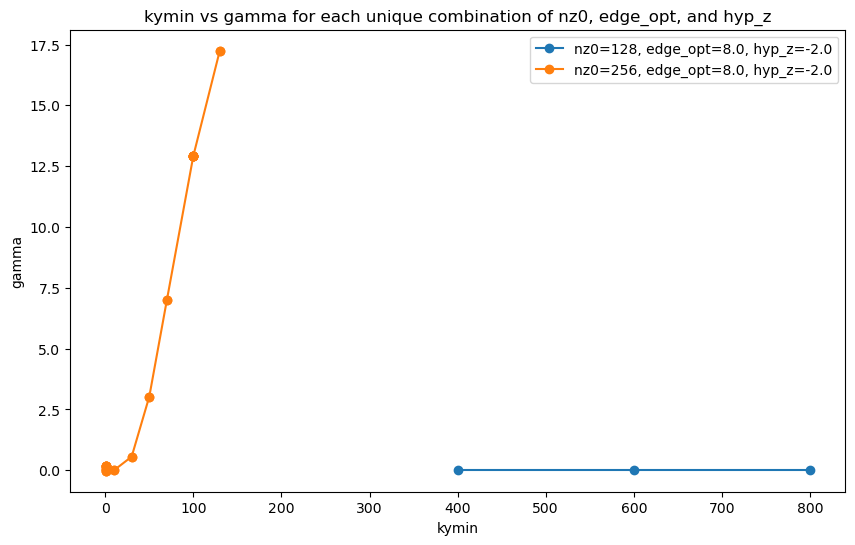

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming sim_df is your DataFrame

# Group the DataFrame by 'nz0', 'edge_opt', and 'hyp_z'
grouped = sim_df.groupby(['nz0', 'edge_opt', 'hyp_z'])

# Plotting
plt.figure(figsize=(10, 6))  # Set figure size for better visibility

for (nz0, edge_opt, hyp_z), group in grouped:
    plt.plot(group['kymin'], group['gamma'], '-o', label=f'nz0={nz0}, edge_opt={edge_opt}, hyp_z={hyp_z}')

plt.xlabel('kymin')
plt.ylabel('gamma')
plt.title('kymin vs gamma for each unique combination of nz0, edge_opt, and hyp_z')
plt.legend()  # Show legend to identify the groups
plt.show()


In [12]:
# sim_df['name1']

In [13]:
analysis_sim_df = complex_array_resolution_analysis(sim_df, 'phi')


save_df_to_parquet(analysis_sim_df, test_parent_dir, 'sim_df_RES_CHECK')

KeyError: 'phi'

In [ ]:
print(analysis_sim_df['phi_fft_info'][6]['ave_freq'])
print(analysis_sim_df['phi_fft_info'][6]['lower_95_freq'])
print(analysis_sim_df['phi_fft_info'][6]['upper_95_freq'])

0.26791345170254477
0.2197871431953463
0.3175893924597537


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plotting_function(complex_array, zgrid, field_name, verbose:bool=False):

    if field_name == 'field_phi':
        title = r'$\phi$'
        real_label = r'$Re[\phi]$'
        imag_label = r'$Im[\phi]$'
        abs_label = r'$|\phi|$'
    elif field_name == 'field_apar':
        title = r'$A_{||}$'
        real_label = r'$Re[A_{||}]$'
        imag_label = r'$Im[A_{||}]$'
        abs_label = r'$|A_{||}|$'
    else:
        title = real_label = imag_label = abs_label = ''

    if verbose:
        fig = plt.figure(figsize=(8, 10))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])

        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])

        # Plot the complex field
        ax1.plot(zgrid, np.real(complex_array), label=real_label, color='red')
        ax1.plot(zgrid, np.imag(complex_array), label=imag_label, color='blue')
        ax1.plot(zgrid, np.abs(complex_array), label=abs_label, color='black')
        ax1.set_title(title)
        ax1.set_xlabel(r'$z/\pi$', size=18)
        ax1.legend()
        ax1.grid(True)

        # # Plot angle difference histogram
        # angles = get_delta_angle_counts(complex_array)
        # print(angles)
        # counts, bins = np.histogram(angles, bins=100)
        # total_samples = len(angles)
        # relative_frequency = counts / total_samples
        # ax2.bar(bins[:-1], relative_frequency, width=np.diff(bins), edgecolor='black', align='edge')
        # ax2.set_title('Histogram of Delta Angles (Relative to Sample Size)')
        # ax2.set_xlabel('Delta Angle (rad)')
        # ax2.set_ylabel('Relative Frequency')

        # # Plot Fourier decomposition
        # norm_freq, norm_mag, _ = compute_fourier_decomposition(complex_array)
        # ax3.stem(norm_freq, norm_mag, 'b', markerfmt=" ", basefmt="-b")
        # ax3.set_title('Normalized Magnitude Spectrum of the Fourier Transform')
        # ax3.set_xlabel('Normalized Frequency')
        # ax3.set_ylabel('Normalized Magnitude')
        # ax3.grid(True)

        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(8, 4))
        plt.title(title)
        plt.plot(zgrid, np.real(complex_array), label=real_label, color='red')
        plt.plot(zgrid, np.imag(complex_array), label=imag_label, color='blue')
        plt.plot(zgrid, np.abs(complex_array), label=abs_label, color='black')
        plt.xlabel(r'$z/\pi$', size=18)
        plt.legend()
        plt.grid(True)
        plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4699188422004337 2.681457078505986 2.877069035470819 1.562941521234693
2.4416378294750034 2.6811427028766137 2.8767562433619003 1.5629422639210937
2.4713569854688644 2.6815281618586244 2.8770700429251432 1.5629420685250692
0.13225497363173552 0.26790863836274403 0.4235300604520329 1.5628705316339293


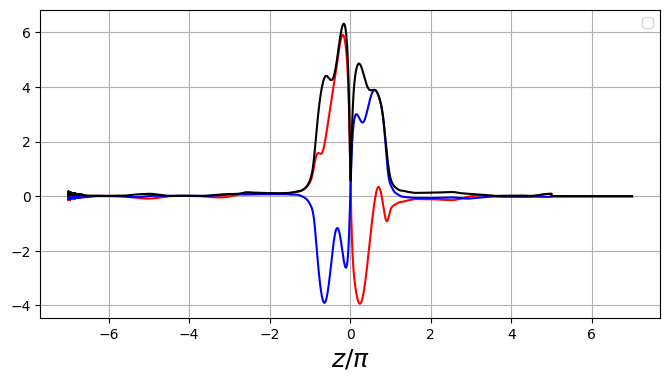

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.030787013773024015 0.0961398229796056 0.19794007860242957 1.5629121787836167


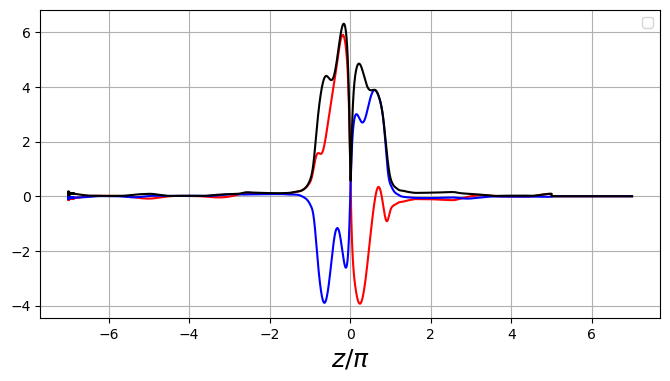

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4692832833282763 2.6788404820319403 2.8754989541701748 1.5629419094282329
0.023224303423631354 0.04503977800737433 0.09859344487207823 1.561363642331973


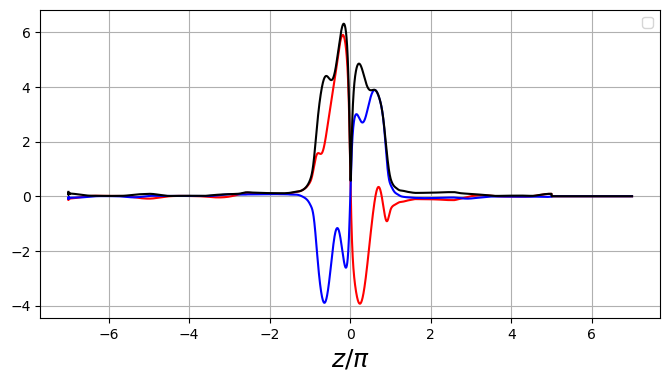

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.440702622337641 2.679278851752173 2.876441396592025 1.5629418903500791
2.4670818696289336 2.678873057370078 2.8767529095905875 1.5629404526824477
2.440695292341861 2.6796213809172187 2.8761278548830105 1.5629422258921875
2.4394466158618346 2.6790296544881 2.8748713434322806 1.5629422941291216
2.4686555221000295 2.6782886994138195 2.8745649793494272 1.5629422621537543
0.1423045173674306 0.2339023761252 0.34594786583147985 1.5629228410021905


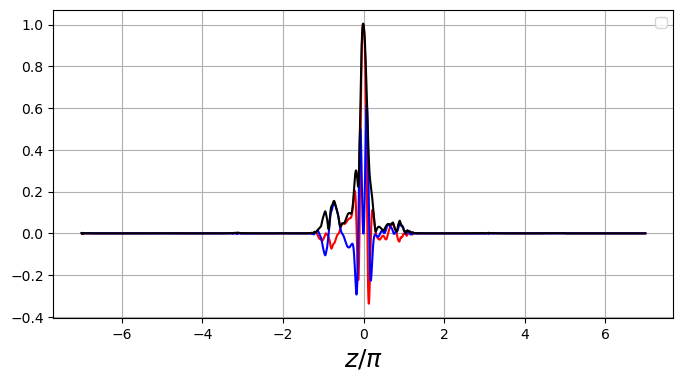

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.09201685759747363 0.15038553472407973 0.23275498845992926 1.5625355970558283


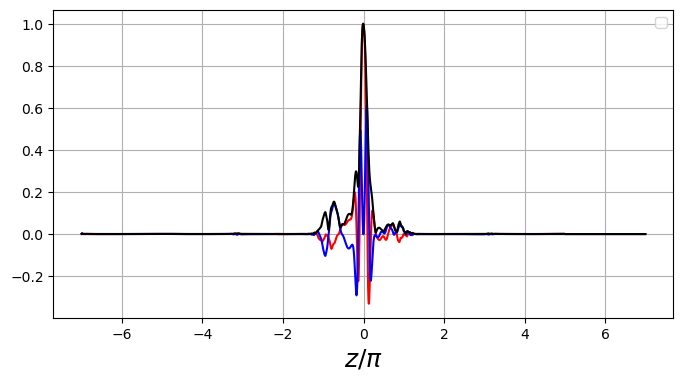

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.46393487281809 2.673566663069031 2.869223798675171 1.5629420042547764
0.06589709730472229 0.09806954743556721 0.15223257280670635 1.5613194860864077


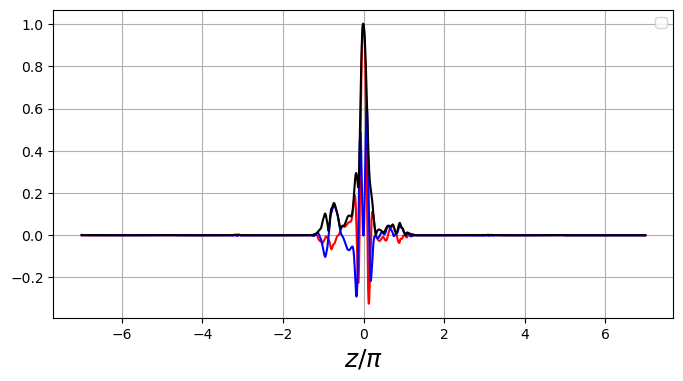

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.472079774823657 2.67913472623901 2.9009699666985136 1.5629422096230652
2.4686391660012648 2.6787088625471127 2.8767633388016227 1.5629418518064622
0.13068888602231424 0.2586635626129997 0.41125373430206963 1.5629259806755127


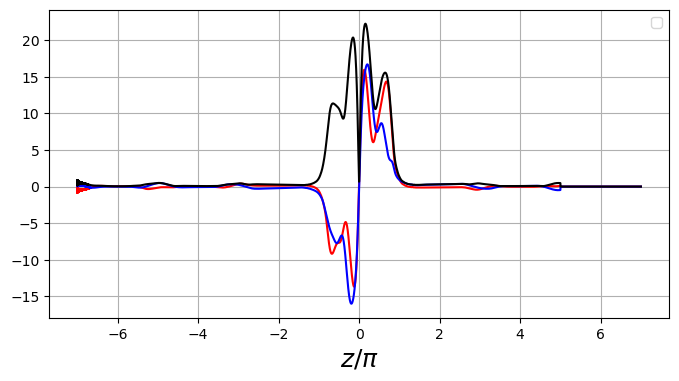

0.032357996595529966 0.08525945305228667 0.1769558304111373 1.5629226510947727


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


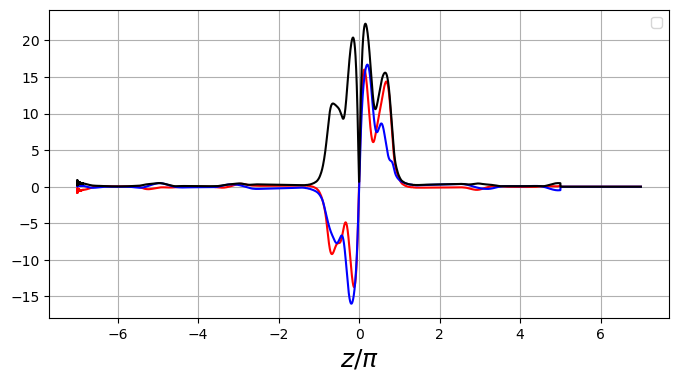

2.4711681828862386 2.680260845683594 2.8767555262620705 1.562941874320607
0.025418015414548405 0.045047278225616084 0.09414864289814676 1.5611682307083745


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


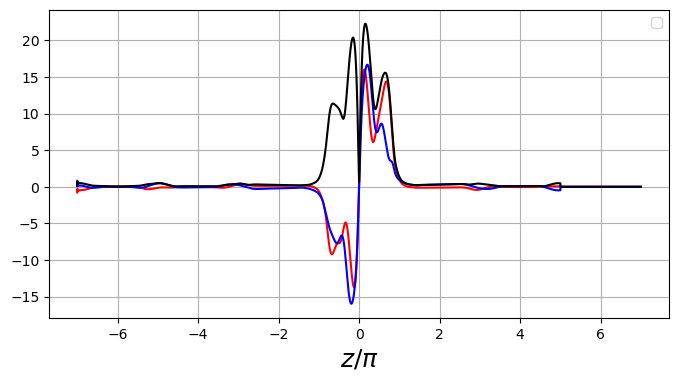

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.440686885908753 2.6791560678227713 2.874870567187459 1.5629418721186326
2.4400348402360046 2.6774899571574364 2.8923925988526697 1.5629417661767597
2.4683178656856892 2.6791173504942742 2.8748792140457926 1.5629423031712641
2.46658993515927 2.67803443693665 2.902203151157926 1.5629422685657803
0.12219788493728308 0.20305999461863164 0.29564992483958386 1.5629140113451592


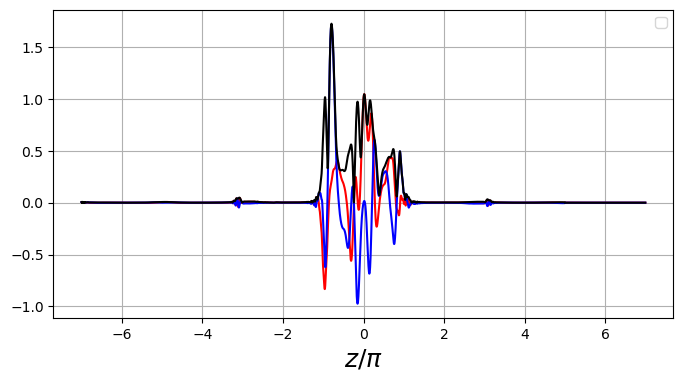

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.07471116285777692 0.12301088031910445 0.19120846197511934 1.5618784965540087


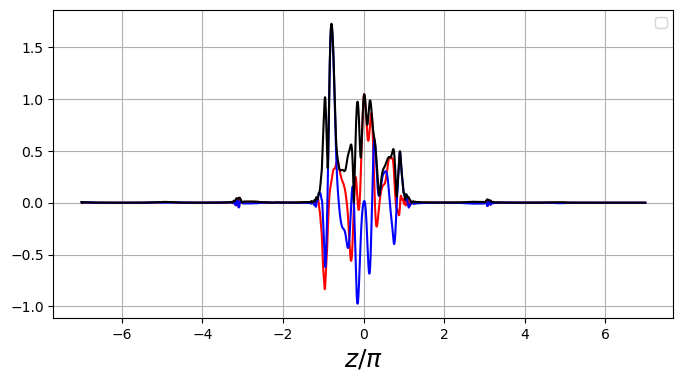

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4658108557793614 2.67644575341393 2.872364088032704 1.5629412954643243
0.055472440439530674 0.07985695248178684 0.12443755596386989 1.5247259181583708


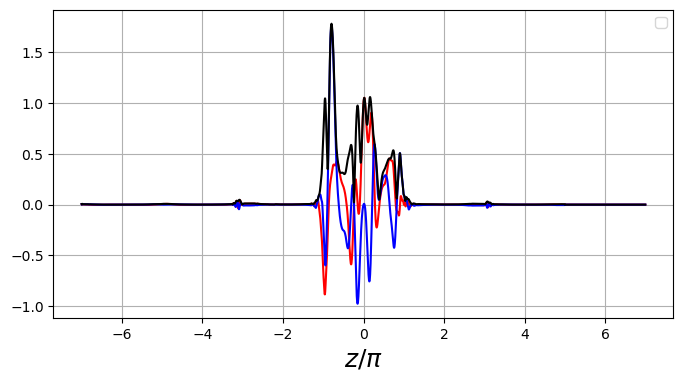

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.440381318487438 2.67983640172648 2.8764422326373325 1.5629423446232775
2.4708543612051495 2.679822809300674 2.8751929771052755 1.5629420878001037
2.428417018737424 2.6644219507402775 2.8619877411994903 1.5629406160776573
2.4724251841913825 2.680904253290635 2.8767559505132465 1.5629421048163592
2.454204004906876 2.6799570999624356 2.8770701745636877 1.562942140036509
2.4413294038641347 2.68056891913928 2.8764395858679728 1.5629409064758806
0.24910833863219145 0.42908457170089476 0.6405553237970555 1.5628664014567326


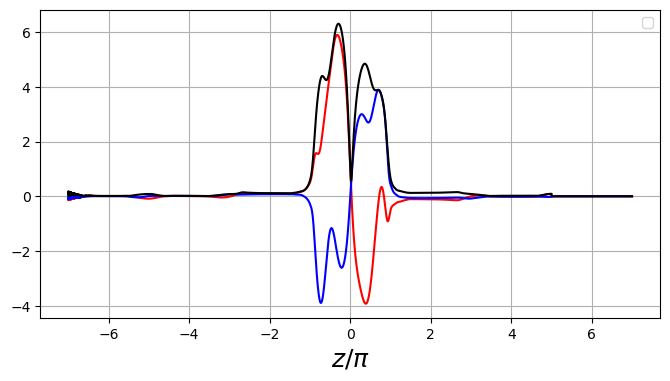

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.14189386982090252 0.27219844366931617 0.43976969416350437 1.5627251145254082


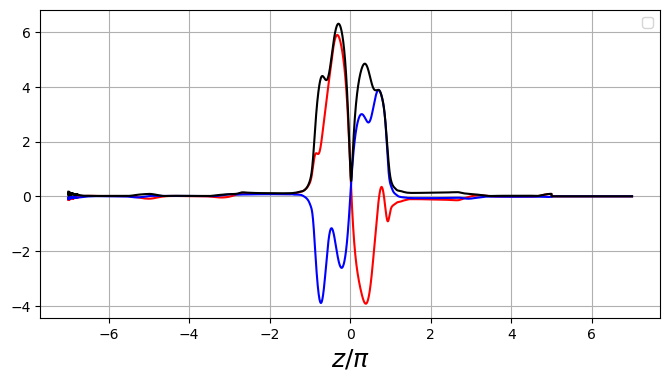

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.03574472304952449 0.06543797441844644 0.1185793356878719 1.5602544169456838


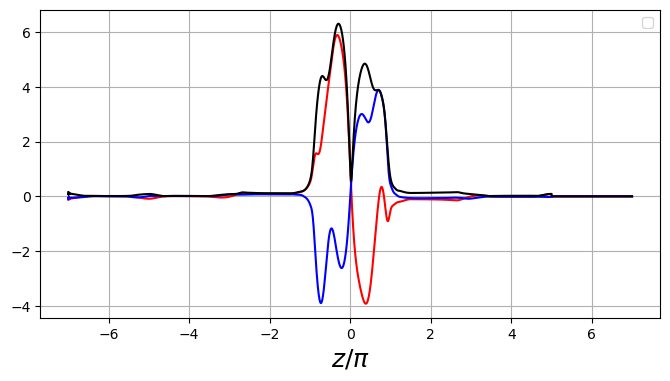

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4717807347601886 2.6801462294058105 2.8764412990037784 1.5629418373245731
1.6090754492732673 1.8178833950380933 2.0376407444765023 1.5629030520716136
2.4410166916456846 2.6796372487203426 2.8761349855126808 1.5629418328104607
2.173954756560412 2.4002778989714404 2.5996869412810324 1.5629396147917858
2.3686856797001363 2.600672156136175 2.7944963398677896 1.5629393790276471
0.12719142536184275 0.2091346700204381 0.3121842873603452 1.562413188086834


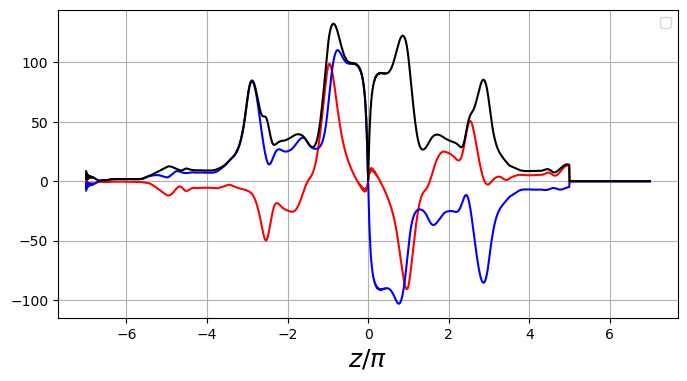

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.466966909958452 2.679655528905393 2.875813755158759 1.5629422582384564
2.4400661634159446 2.678197867876259 2.87645676670062 1.5629417067770044
2.4428674883055685 2.6793534281806037 2.906291002456568 1.562940078231485
0.3498122753497455 0.5093479867962502 0.6920615939134956 1.5628539983521028


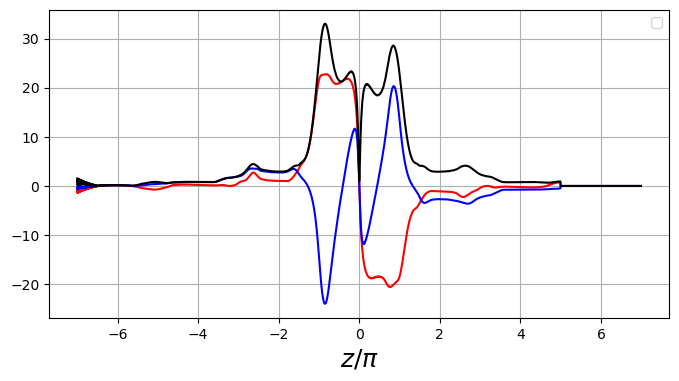

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4718012663594977 2.6801429436485966 2.8758094550400157 1.5629399212173996
0.07945882210392463 0.14871662423054416 0.24187045601891283 1.5624807903834983


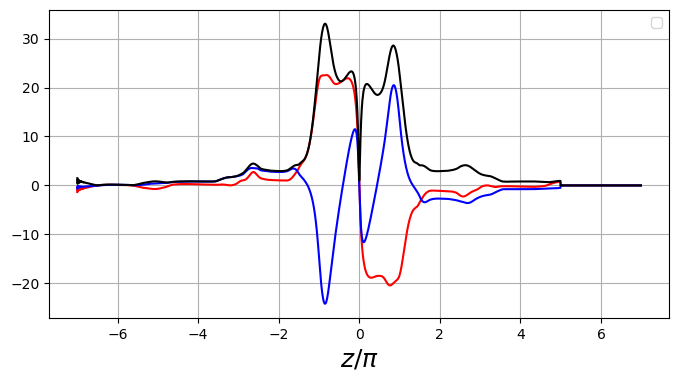

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4686526222993286 2.67766915034663 2.8745537487760977 1.562940426247113
2.424341044651074 2.657740993741531 2.853865621689031 1.5629357060936109
0.7702865353478189 1.0185389801803095 1.2786718788458475 1.562909322521013


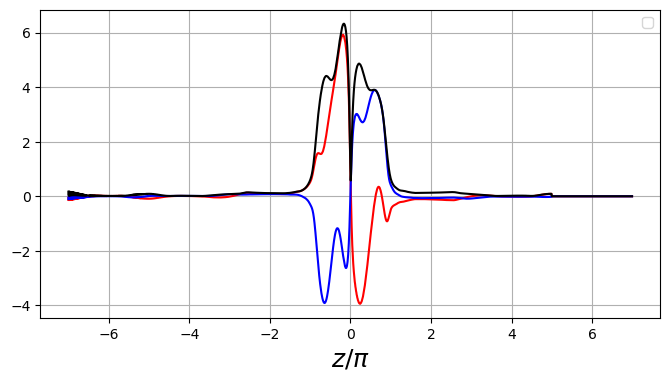

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3034612707479724 0.4774856102797076 0.6591513693460929 1.5629378559668332


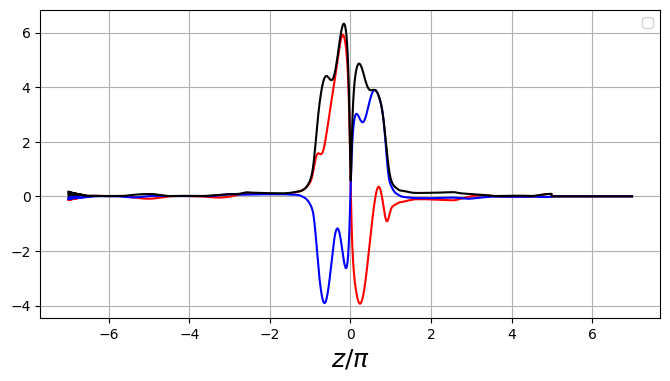

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.442579096485451 2.6614805876630525 2.858524398575063 1.5629364636675394
0.09591227845828401 0.1763425271768147 0.2828072044588313 1.5596129607124132


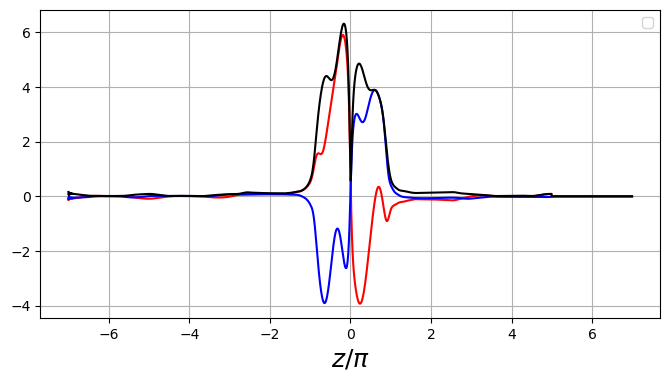

2.4400505079560326 2.6805586540472848 2.877060178301824 1.562936709658394
2.371230638308316 2.6042879137040615 2.8114298162753086 1.562939559224798
2.440685567479695 2.6792235790412686 2.8767604189342793 1.5629359984053859
0.7344385406458285 0.9730440626887082 1.2183100303606251 1.5629025556442868


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


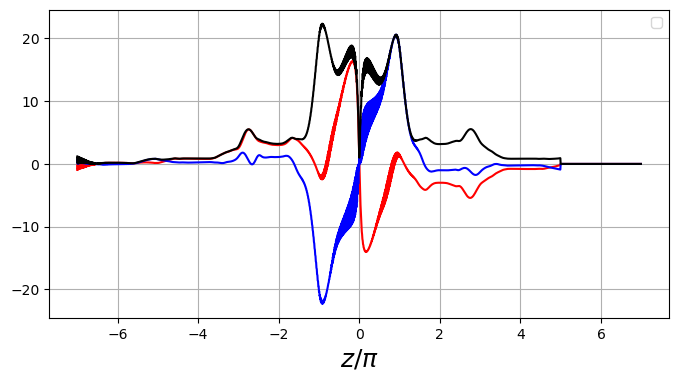

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4714752739323878 2.6798929175895116 2.8758048242910506 1.5629374045060054
0.08350784852843343 0.1520172787020293 0.24272068777017877 1.5621415545364028


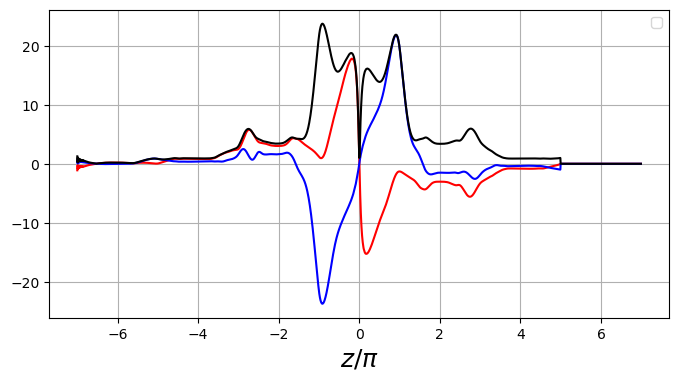

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4679298099109177 2.6782656086967265 2.8736109845755027 1.5629402698440065
2.457642453602908 2.677258125041858 2.8761244931638275 1.562936131085392
0.9377430505478419 1.1917082143323854 1.4518531892923032 1.5629312639995692


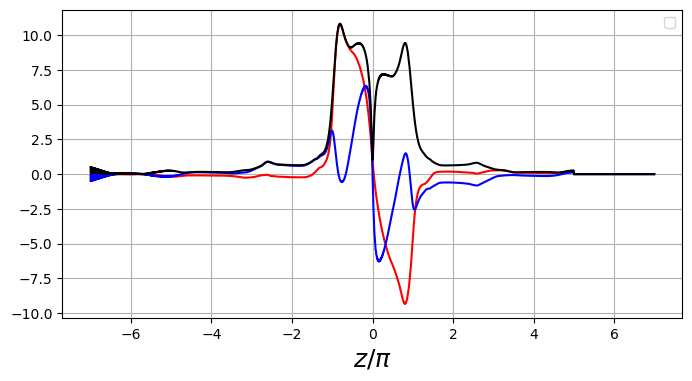

0.32105995949611166 0.47961203102197114 0.6569241759308279 1.562889724552989


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


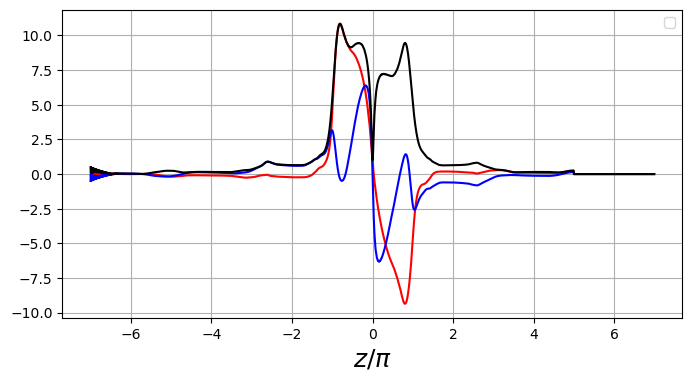

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.47085212840047 2.6793283845469995 2.87548754370623 1.5629357074116133
0.08230068136913739 0.15312848521106562 0.23970004727417432 1.5629197053591315


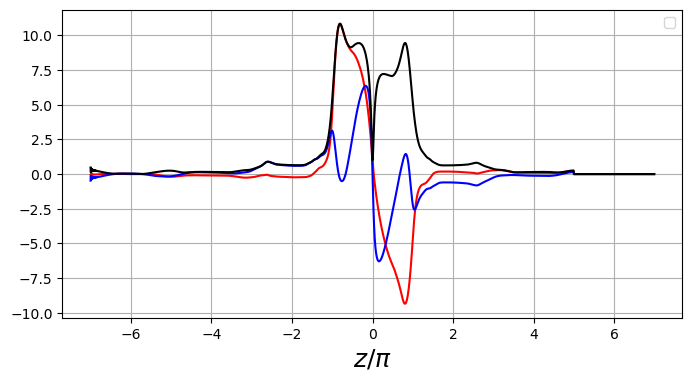

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.456163199159261 2.669392452084532 2.868895691337878 1.5629344055021681
2.4533468680605965 2.6680882074523065 2.8588712744971074 1.5629414692321886
0.7020786576012042 0.9167468281275405 1.1485361266839902 1.562879947006428


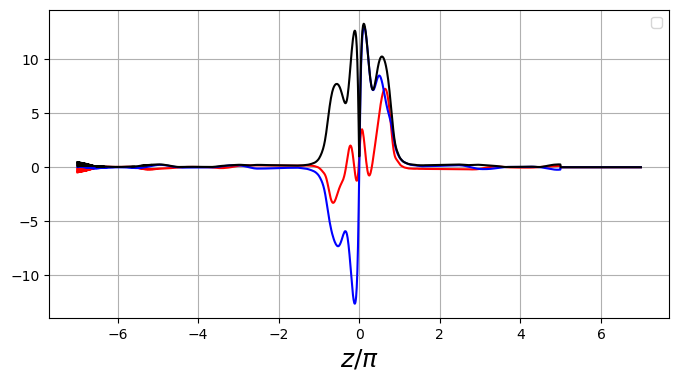

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3116133680748575 0.47394548999154357 0.6475105412279079 1.562896898628844


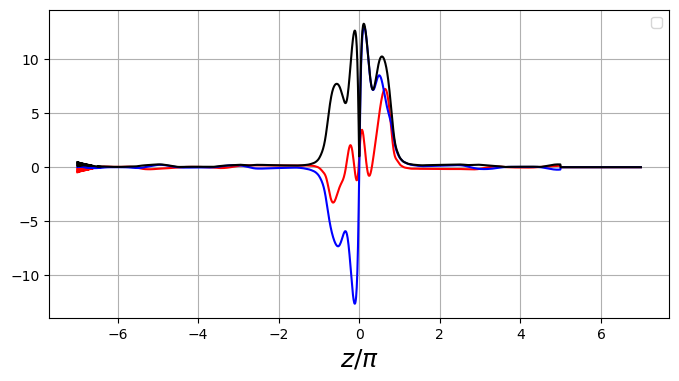

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4368870433997465 2.672251036656664 2.868541512886318 1.562912600349844
0.1028720074423205 0.1886360594297626 0.2832273363438645 1.560329990931538


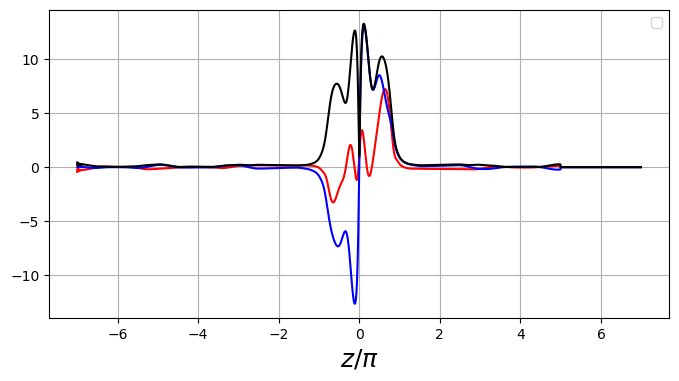

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.455436310456661 2.6622090021760476 2.866073703642078 1.5629416502925944
2.431536051191977 2.6601287561732274 2.868262840672978 1.5629362138387808
0.6461979670408197 0.8606751875453119 1.0707135424618361 1.5629134816247734


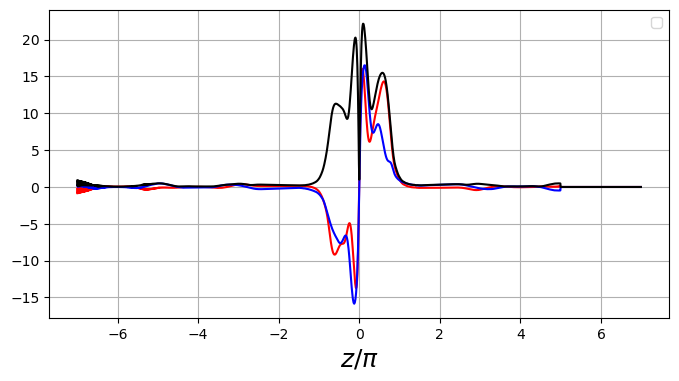

0.3115733408781541 0.46485325822708523 0.6577790304210255 1.5627749170700107


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


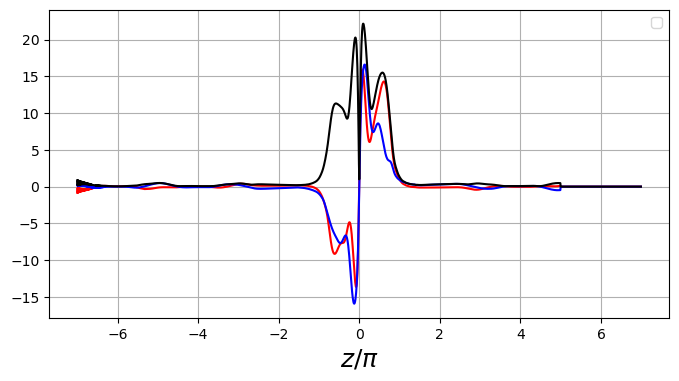

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4573176258489453 2.667655318758174 2.8874595392803206 1.5629243494895477
0.11054461811057689 0.1888752670637156 0.2856806226037011 1.5584003261550579


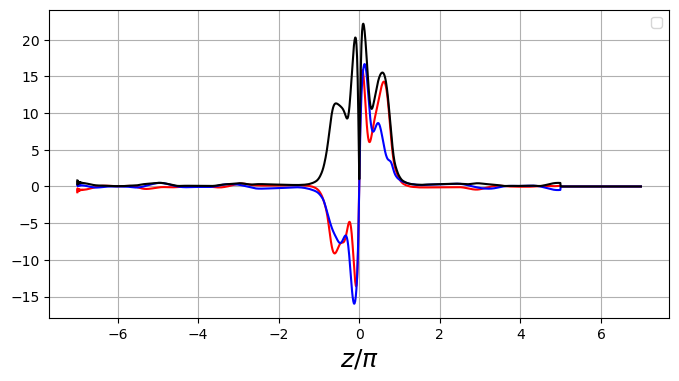

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4174407033654957 2.655278867824442 2.84940704087395 1.5629327484396804
2.4157818417572057 2.647037824495203 2.8516049266118855 1.5629062547048505
0.635512185804199 0.8245605836245299 1.04646631314709 1.562921573649982


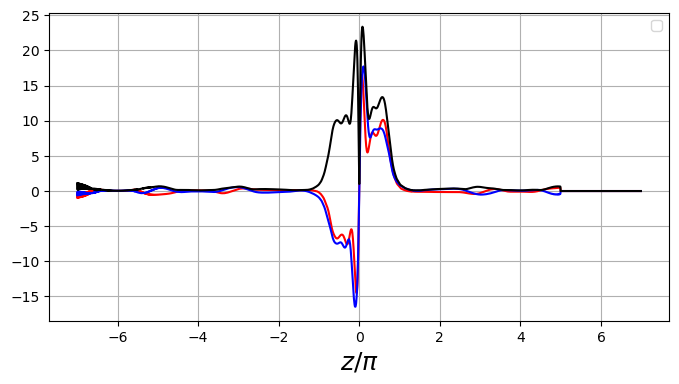

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3084575524397817 0.46890995890294485 0.6436787725488637 1.562784585149869


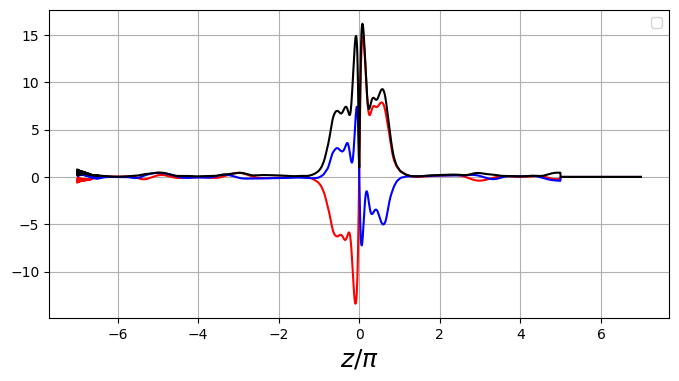

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4331472104622205 2.6679926878205986 2.866080737304816 1.5629369200093666
0.11363931189298716 0.18800846497216123 0.28613314344405044 1.557453379249618


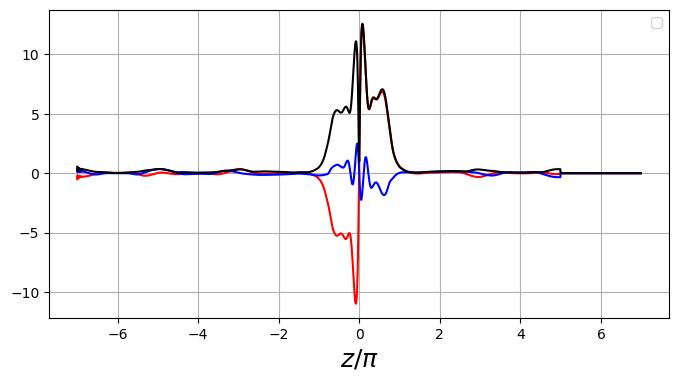

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4274535965329407 2.6606835243883245 2.8579118242083497 1.5629321870421584
2.440973519814423 2.6568786276022966 2.855080425327156 1.562934305599397
0.5580805351336641 0.7463039079987956 0.9389623784614104 1.56160221732331


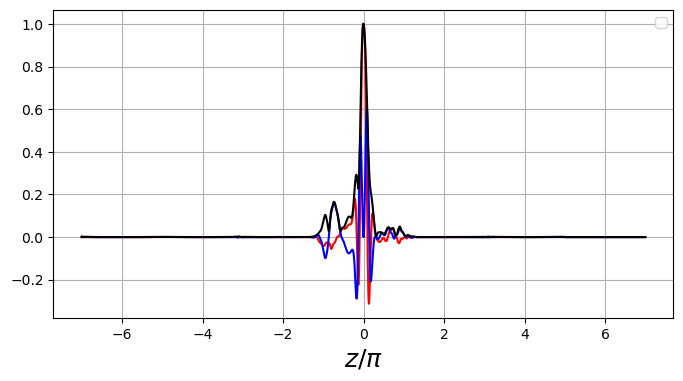

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.34732662766055494 0.4858584319886482 0.6407159165017874 1.5623770633253562


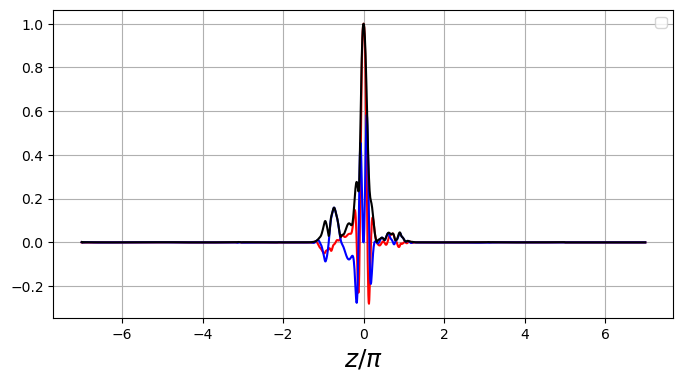

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.427792707496131 2.6384668321125213 2.8339929741601018 1.5629128589739005
0.15925299447186617 0.24428514055103953 0.3474432317755286 1.5626896400345842


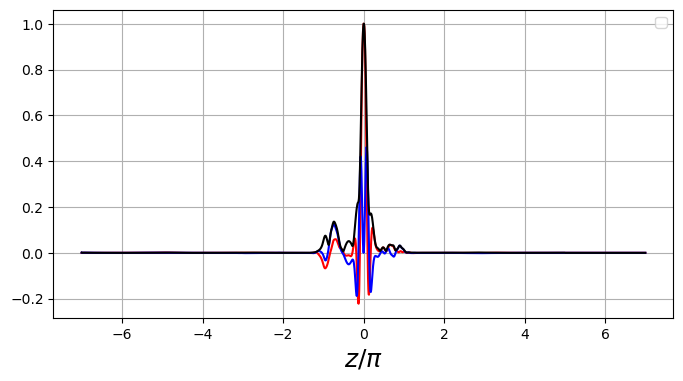

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.467312375315195 2.6802787063672326 2.8987458778914066 1.5629372135124542
1.9690555723495198 2.1913573153862163 2.433046491360406 1.5628671781172399
2.471165108368541 2.6797919429314647 2.905049799226038 1.5629399297777447
2.3793836502482195 2.611555512455708 2.8116732830928046 1.5629089956046718
0.10391704802601405 0.16410763717514615 0.25466309435425627 1.5620131850726486


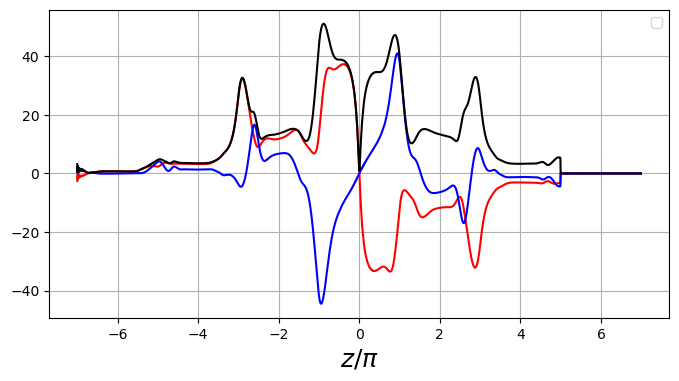

2.4636267965497347 2.677002999247546 2.8739262666403516 1.5629408806882106
0.791262045865596 1.0580983787674796 1.335642982122577 1.5629363368363682


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


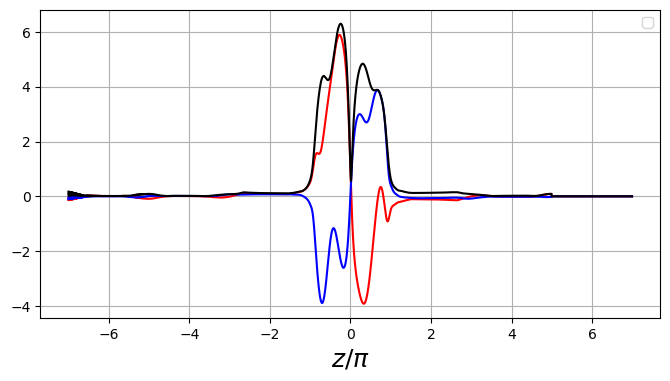

0.28672980419762545 0.45666415759162454 0.636383444608619 1.5624960577065412


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


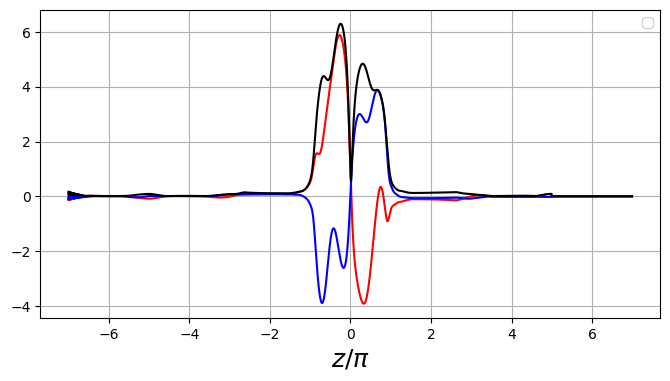

2.431576818969091 2.6608059174420347 2.8790102642751014 1.5629422249977363
0.11478906271337555 0.19635713077847633 0.29358680900686474 1.5604223977021472


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


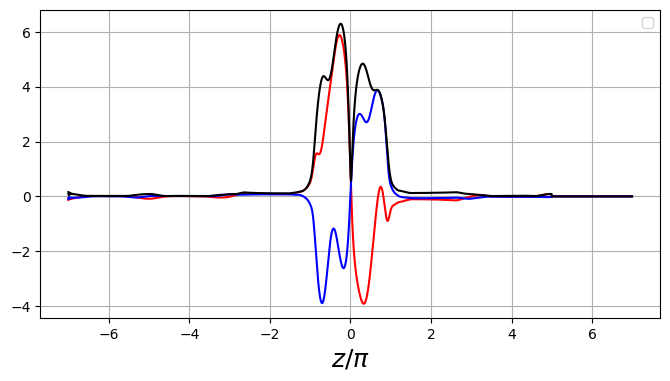

2.4717891301474575 2.6802787063667854 2.875804472862435 1.5629372135121935
1.9645868717246513 2.1913573153862163 2.4194126349724088 1.5628671781172399
2.471165108368541 2.6797919429314647 2.8761236295709045 1.5629399297777447
2.3972039543237322 2.611555512455708 2.810204619865779 1.5629089956046718
0.10298297983996728 0.16410763717514884 0.2524338896077247 1.5620131850726744


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


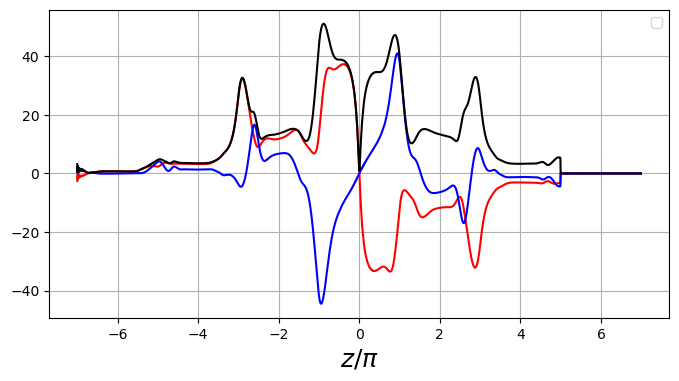

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4324734889885202 2.6603603684869612 2.858838657923573 1.562927931513538
2.4196288390628946 2.6556880488971215 2.8572558792518827 1.5629256653256163
0.4325735222243075 0.6020337448449612 0.8033687786107777 1.5629131581146227


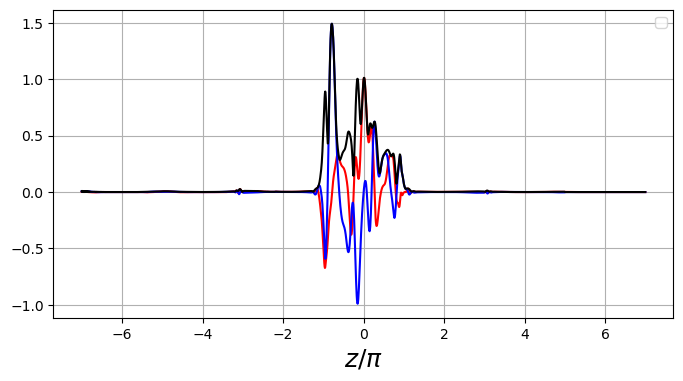

0.2934833703407706 0.42980353290849715 0.5706851904211768 1.559955946948726


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


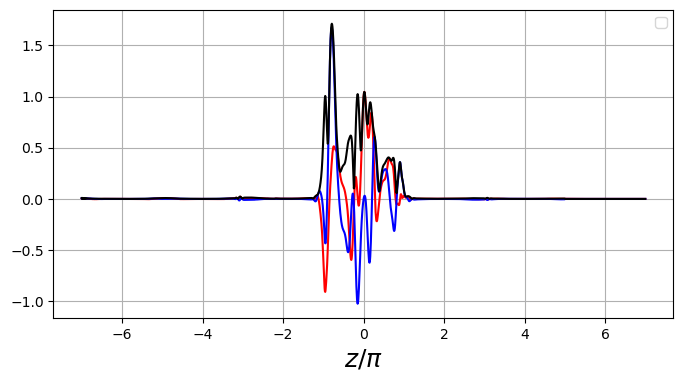

2.41489873099358 2.6443570480475467 2.8393844572146922 1.562919248038801
0.16051241282706485 0.2283986531123321 0.3166978806973226 1.559895011602574


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


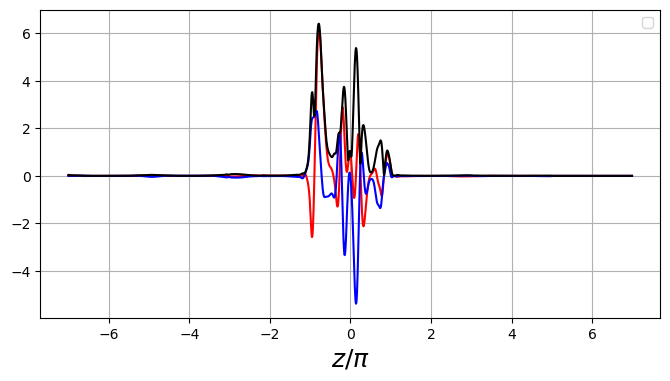

2.420873071762724 2.654840319372851 2.8481663541047246 1.5629328772366136
2.428186879703464 2.6456983657113 2.842497915380239 1.5629340328267785
0.6442251669995624 0.8536159018167941 1.080872863960894 1.5626812641903602


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


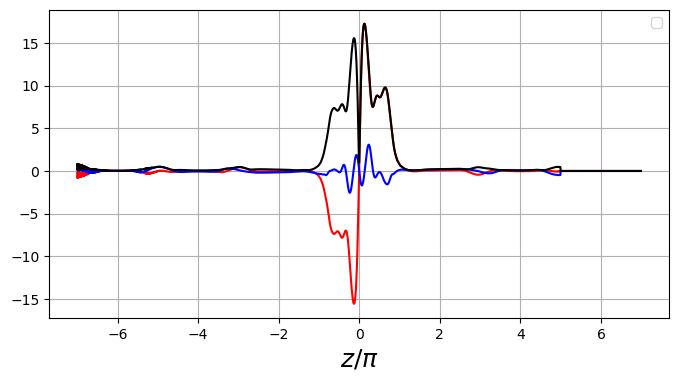

0.29248132546607847 0.4537743802798373 0.6280180383168252 1.562937265514222


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


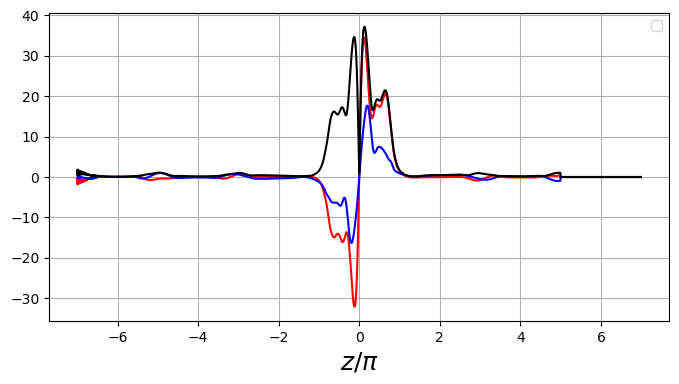

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.458907029366554 2.667280378148984 2.864847621550738 1.5629411802935507
0.122175559076894 0.20040739649396647 0.2956037612603428 1.562628463031166


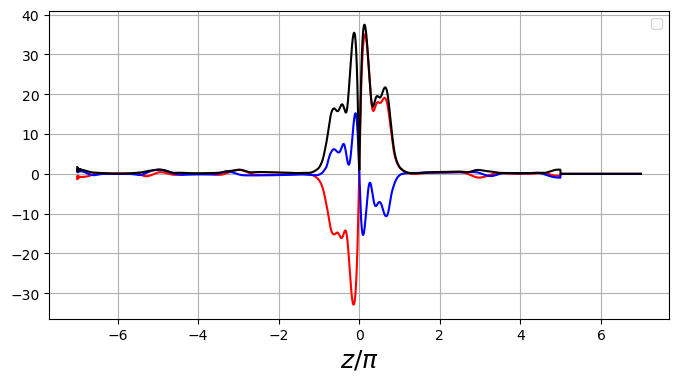

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.470854354979897 2.679058502942045 2.874878810648465 1.5629420838623118
2.439122181245931 2.6774415321313767 2.877020478237377 1.5629407425575823
2.469594186984599 2.679528543062262 2.8767517986277755 1.5629398490961213
0.32793444944242156 0.49744617383829187 0.7096476983910859 1.562789296399298


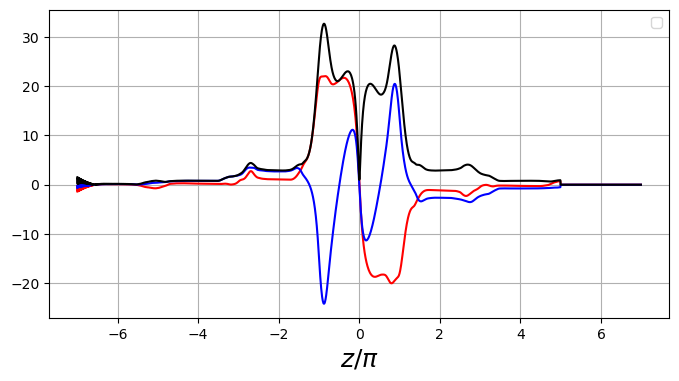

2.4416221290973765 2.679936669367775 2.876109430599877 1.5629322137885735
0.08710664751497606 0.14827773376023973 0.23502108332127725 1.5589731860311393


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


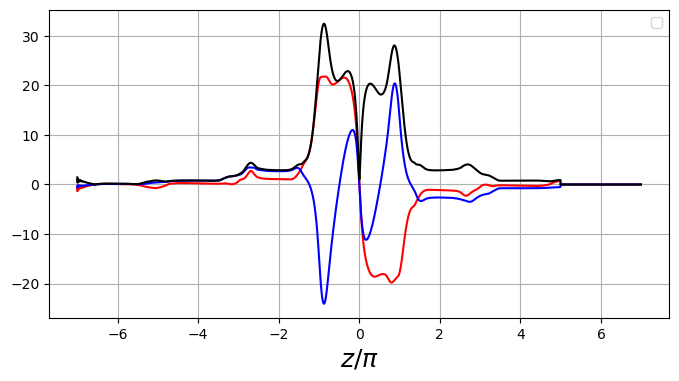

2.467371662626398 2.67998502477891 2.9053561293818433 1.5629399434123594
2.4016750167314487 2.6154442611105857 2.824311763279273 1.5629360098680092
2.471791135092051 2.6792804874708924 2.875500500989889 1.562938481258895
0.7197425176717036 0.9824110161597128 1.2219748205424281 1.5623365004654328


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


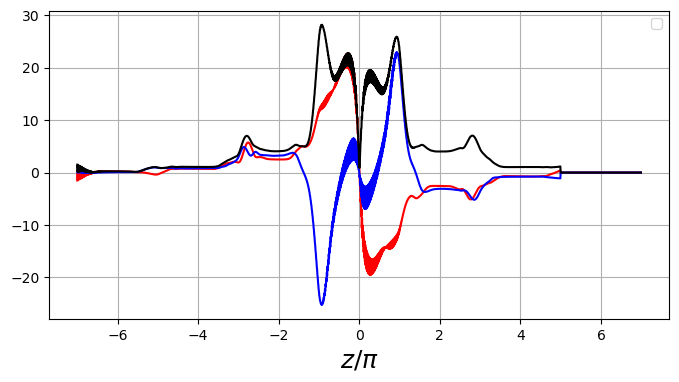

2.440380103478959 2.679391081051068 2.8764408005243767 1.5629415664710327
0.09448847066904062 0.15815011943306445 0.23859908419857487 1.5617280451112192


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


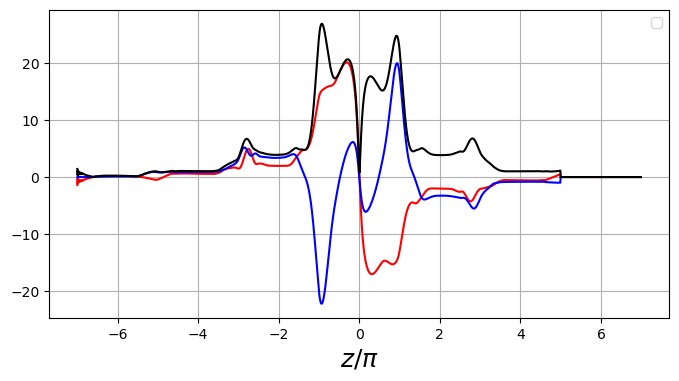

2.4585500101908733 2.669356495910082 2.866703523641806 1.5629339050326285
2.463625559405432 2.668173616793856 2.887150909495614 1.5629400958358102
0.7481807867963287 0.9676961771890702 1.206073868332951 1.562882239778191


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


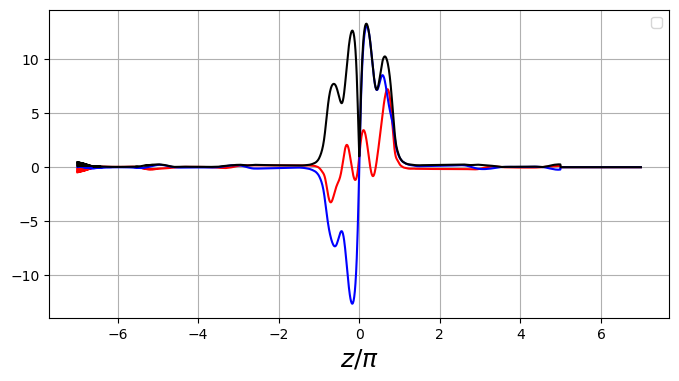

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.2926047914227197 0.4548011535133247 0.6384903737724587 1.5620031518086066


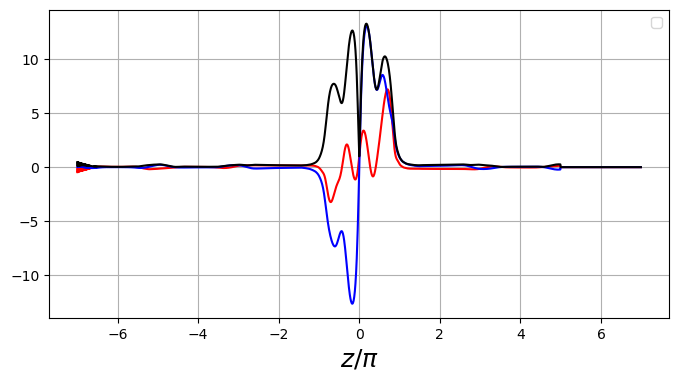

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4563999838709973 2.6721752766876494 2.8692125313987855 1.562940144936927
0.11863103727828476 0.1966969640387818 0.2909555852447965 1.5614509172814781


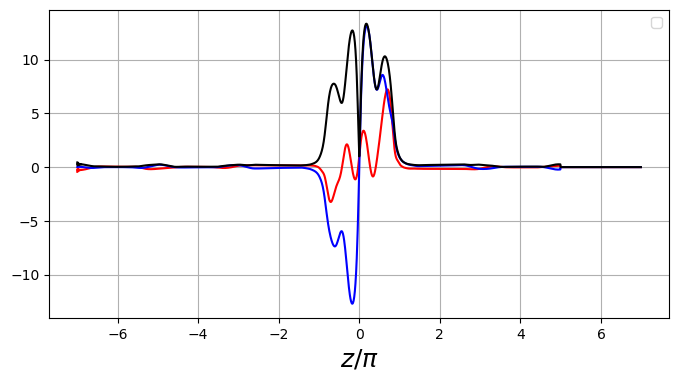

2.416752957405361 2.6386449274624555 2.8302682994448833 1.5629247890042923
2.440945874462954 2.679462828321925 2.8757387938614842 1.5629015184029802
2.461306503612932 2.6762271000663427 2.873294013994828 1.5629387403918942
2.3956118967714644 2.6235280796924383 2.8129113749294583 1.5628899791741815
0.07148182405149078 0.13486202933709598 0.21575454821726428 1.5599169850034729


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


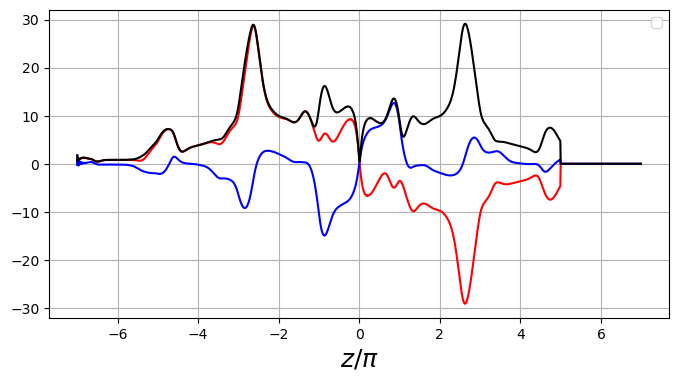

2.4695147984154806 2.6799839418286524 2.8758083337981306 1.5629393118468102
2.0181431805478383 2.2389198074378402 2.474066761953367 1.5629421653695146
2.4692853149936207 2.678420059996705 2.8751780156261604 1.5629382241848933
2.3498728624159537 2.57548433159986 2.7756252337510103 1.562927224181896
2.44007170829268 2.67886226281261 2.874247078790066 1.562940227727061
2.437363935476994 2.677021460433366 2.8729926207531227 1.5629414122155794
2.4680209816595546 2.678736141063996 2.8758143663435924 1.562938321946835
2.4708358134377737 2.679906899953164 2.8751726793663663 1.562935323409929
0.08066786682922071 0.13228865921373167 0.20329584620665112 1.5558156133955152


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


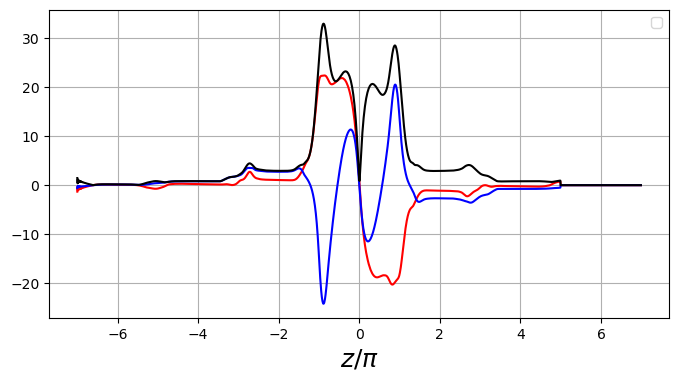

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4149095805320187 2.637787054216761 2.821163098559706 1.56293643598016
2.453858653454383 2.6793494300732843 2.8764039402758517 1.562917270635713
2.41522326876237 2.622184441424471 2.8189529639380497 1.5629259671230447
0.08202239023138436 0.1489374381430605 0.23833023531481232 1.5458334743863515


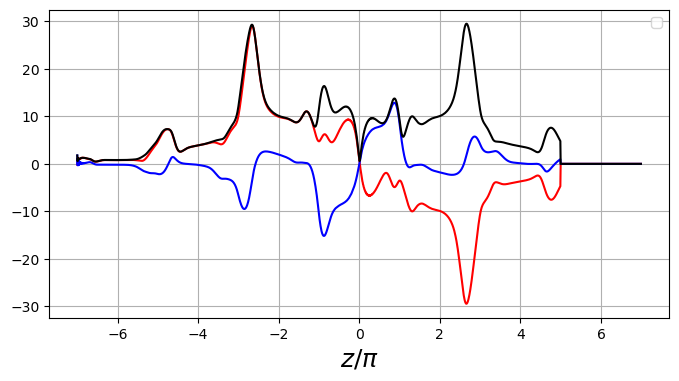

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4608918921750123 2.677887669423792 2.8739150842706147 1.5629347993273184
2.4356420438787794 2.6763703161269228 2.8748568267028425 1.5629301321815467
0.9211238844257523 1.173575577663189 1.454584703682725 1.5629041727833695


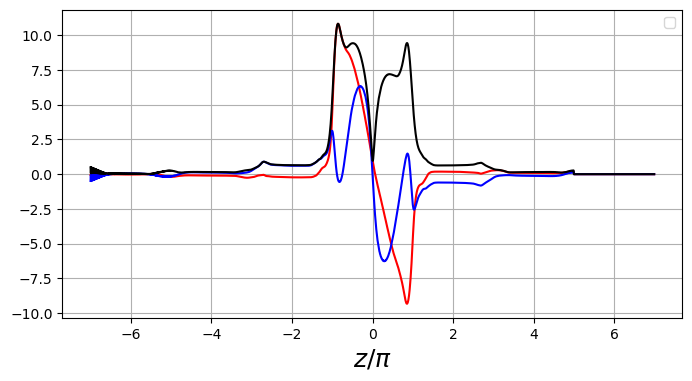

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.2990548707313078 0.47059803244445897 0.6631605961139307 1.5628540475204251


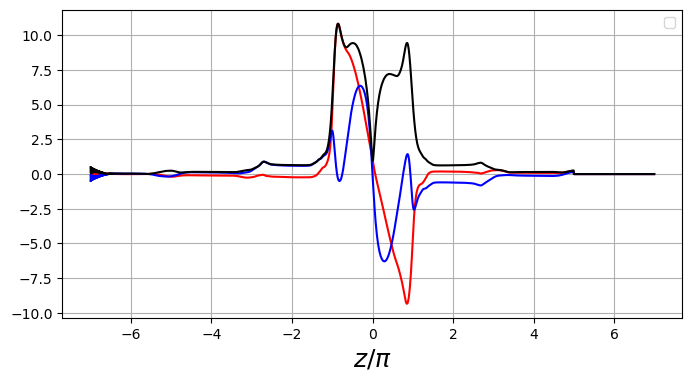

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.43975000586971 2.6786870958665254 2.87455374936281 1.562940426566118
0.08783787992322255 0.1455273424757132 0.21995157305892754 1.560830262052084


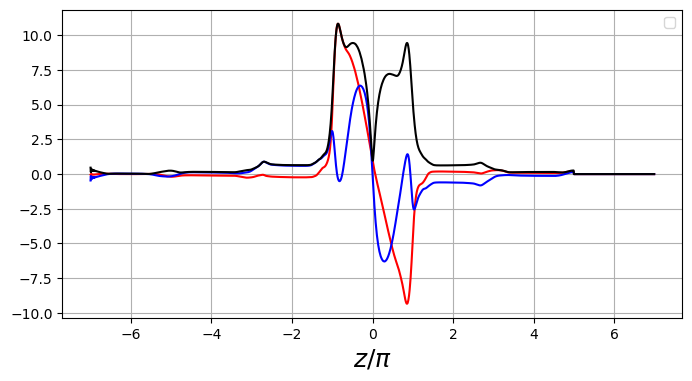

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.465169681611618 2.6766823642789976 2.898127103869205 1.5629381241022315
2.443501690164417 2.6562720224224634 2.8584187496298137 1.5629388183311073
0.7818670268467801 1.028784295812338 1.293310690403397 1.5628230613562868


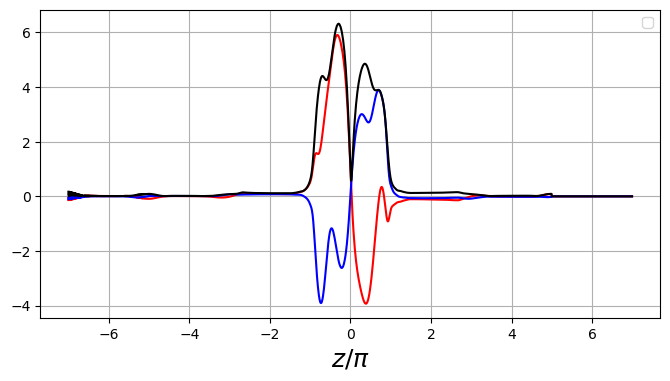

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3185149395724797 0.49170763538510476 0.6829852397558608 1.5627335546085668


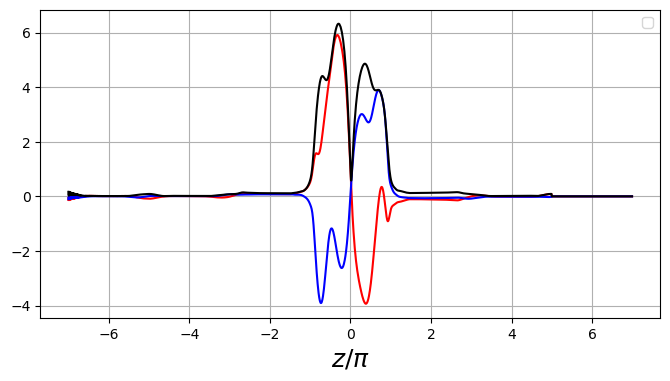

2.4274652550513216 2.660880752321957 2.8563533688092404 1.5629346366434564
0.10216024412719396 0.16890736459183042 0.2541549447645935 1.5590405353766563


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


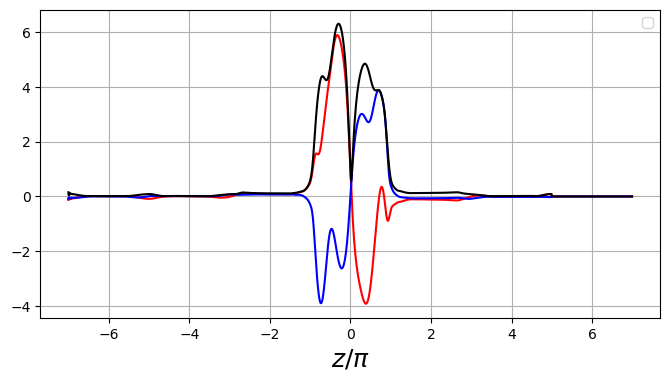

2.4450145111366903 2.668808567897537 2.86672608761207 1.5629419249562375
2.4334091825930186 2.6674344565507653 2.8648010445974696 1.5629286241536138
0.7296238409085195 0.9542750263506486 1.2099346656082117 1.5629186688998424


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


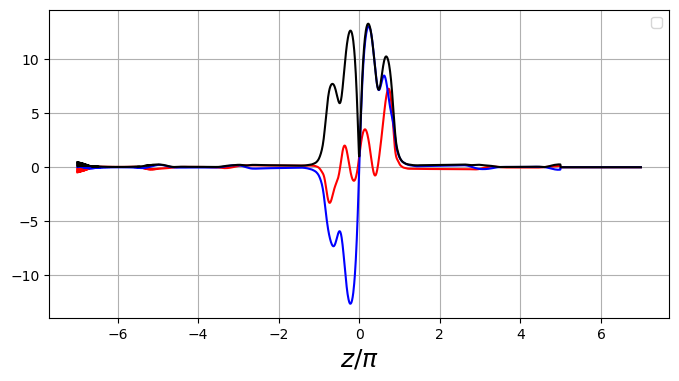

0.35966708400138603 0.5396719772514007 0.7467272022407536 1.562847996949054


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


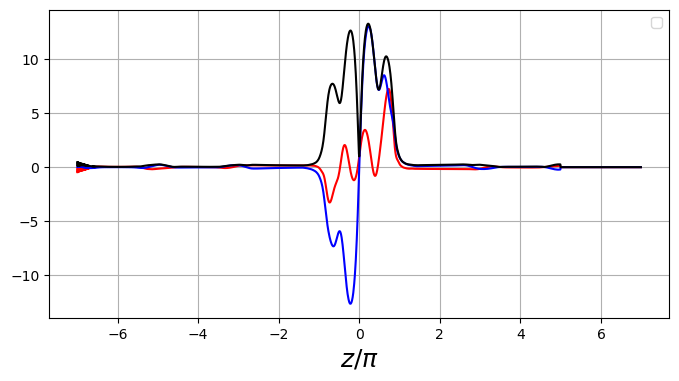

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.464250420429999 2.671767777303789 2.8695304289557417 1.5629379035041855
0.10953795733780268 0.17714811400230832 0.25077601121176024 1.5614651511620867


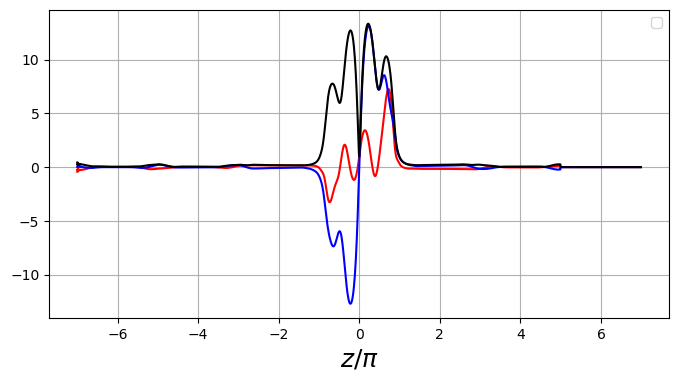

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.443178922264193 2.653656139123262 2.8494407878917567 1.5629383351032367
2.435304608028069 2.6452001624210526 2.837812810473397 1.5629403946734661
0.6628083597969944 0.8763582505698884 1.1001282113947486 1.5628382951953497


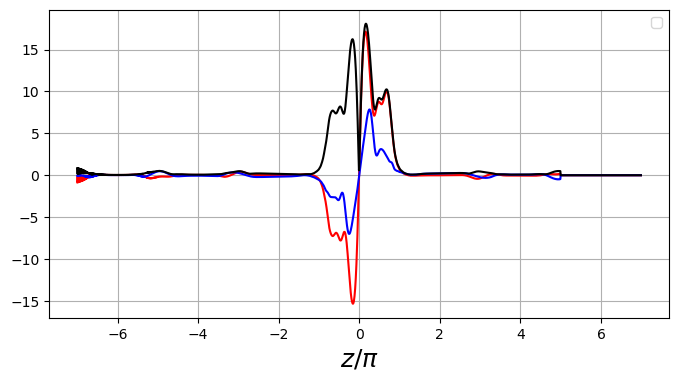

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.36967601234598235 0.5344782777989296 0.717772670415332 1.5626970527838067


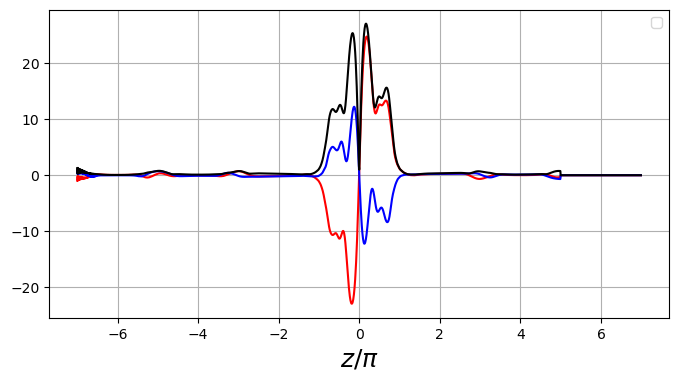

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4315639521201056 2.6675223728405593 2.8638775926931697 1.5629390028711545
0.11873453430317778 0.1789169412422061 0.2557371221204927 1.554894204154539


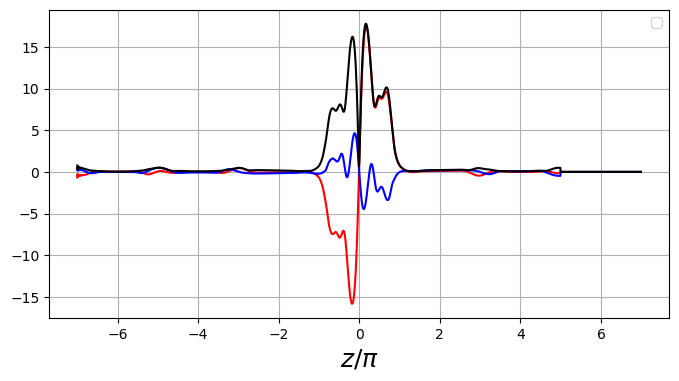

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4233591912415715 2.659988292684905 2.850299351778398 1.5629052435906026
2.4421564142864014 2.65535693873646 2.8519444581004634 1.5629373796189496
0.543231787565897 0.7326043323995519 0.9399908636024938 1.562229048897562


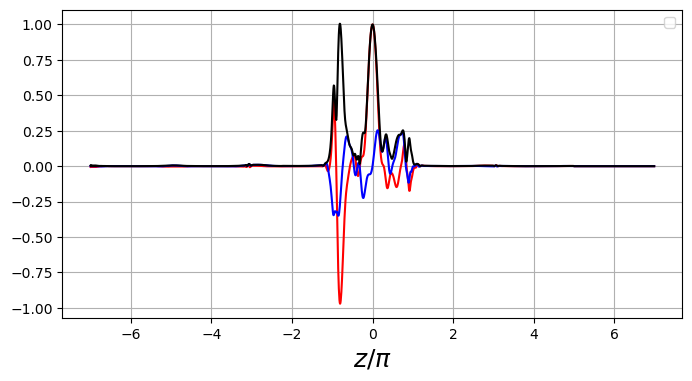

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.3620139384297329 0.5071365377249183 0.6672350661447964 1.5620966596018226


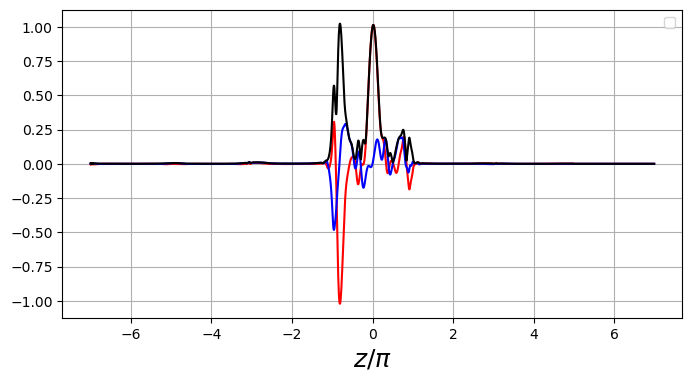

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.433438151096408 2.645730662241992 2.8399706585504476 1.5629220081015793
0.14216105043940624 0.20619352515557327 0.2868271414151897 1.5578220835595729


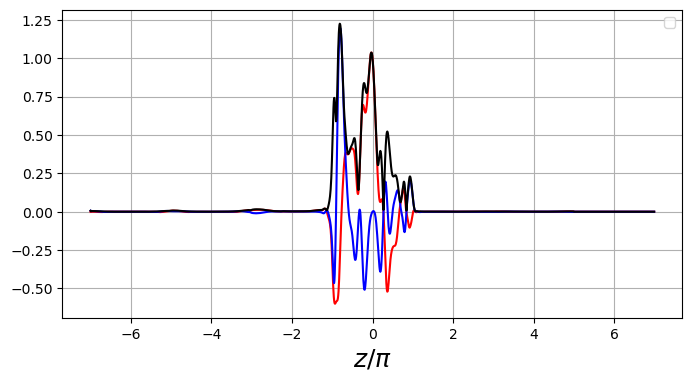

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4597154269258046 2.681314268024421 2.8770677505706304 1.5629408232243815
1.886764483458763 2.1253752158485684 2.328565398925636 1.5629378898156099
0.1680268028934447 0.2985367325492441 0.47187932931868487 1.5629304373093156


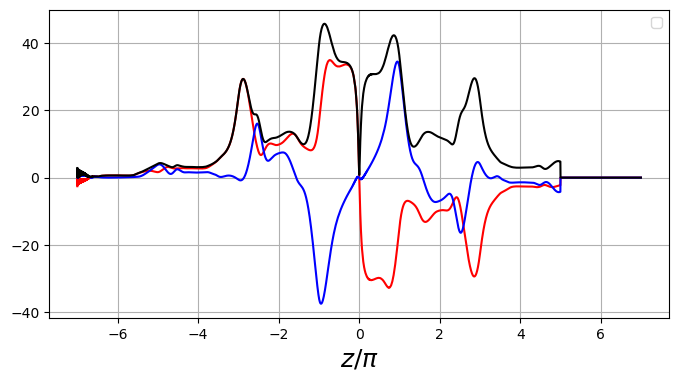

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4318664149279723 2.645461787409205 2.8378149652804256 1.5629415814448187
0.03281156651167981 0.07102149981962332 0.1419100251630151 1.5546432704343527


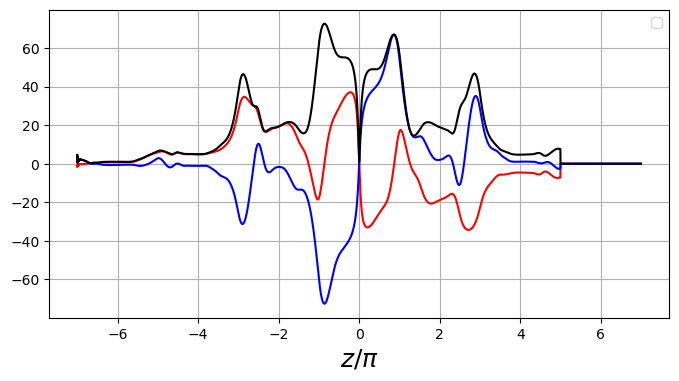

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.441642343249905 2.68118151424767 2.877066466737343 1.5629401257936535
2.4410083865738237 2.680271815709313 2.8764407591362806 1.5629415439824157
2.4727474819403135 2.6812641522307583 2.877070440809224 1.5629422846719683
0.03704823403371186 0.07316077290488736 0.14321548744288443 1.5623222235025764


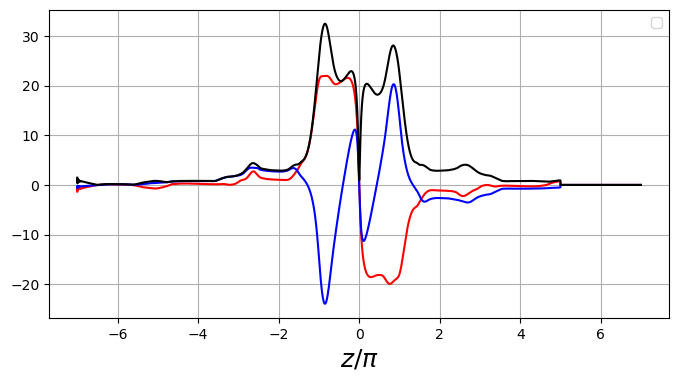

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4416458028546915 2.680764329320719 2.8767563840376233 1.5629423403502427
0.2550187506541908 0.42651370457296767 0.6082720654789525 1.5628940094294583


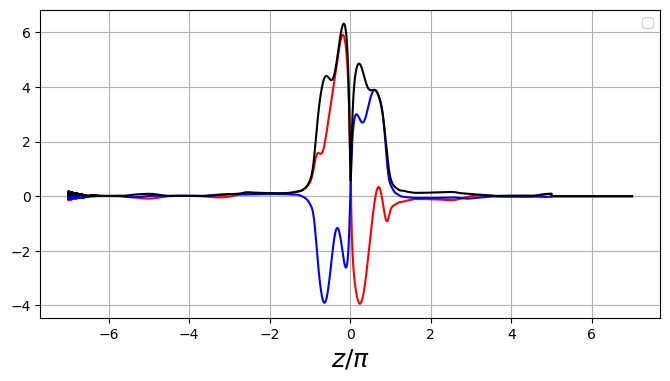

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.12407990480764847 0.24831064638442313 0.39769965438410954 1.5627785478937997


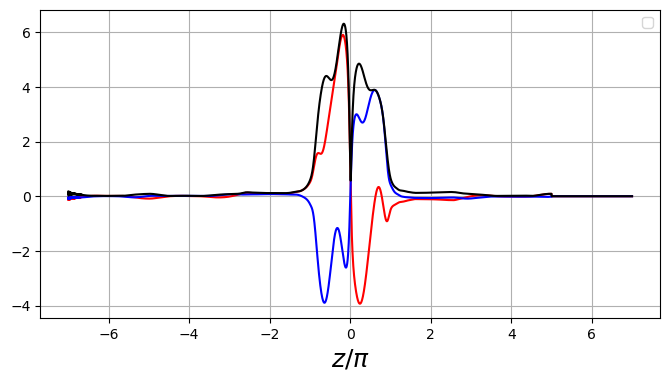

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4362962540576425 2.6738170107519332 2.870786194614261 1.5629417069605984
0.03546237714511316 0.07471555226810678 0.1475219197919387 1.5612860734242302


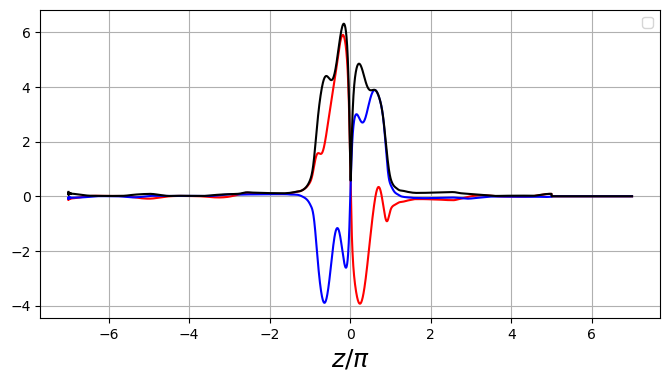

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.437227104725332 2.6749530343655885 2.873931191191611 1.5629392875706243
2.4642626910461227 2.674034558426775 2.8732976252304727 1.5629407047366728
0.2491085715165181 0.3992754682271633 0.566747720764148 1.5628678625362429


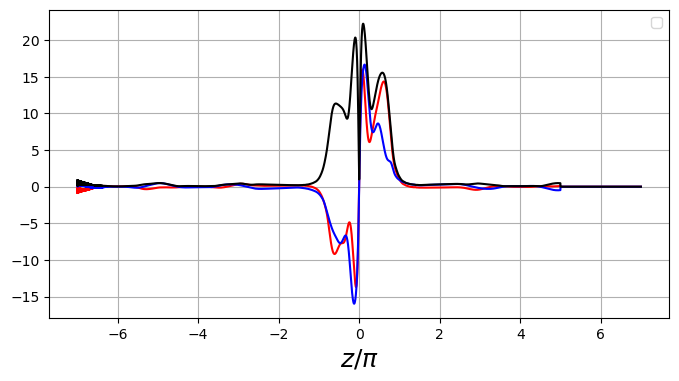

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.09957129948770632 0.21291021089115286 0.3405402839092523 1.5627958512543227


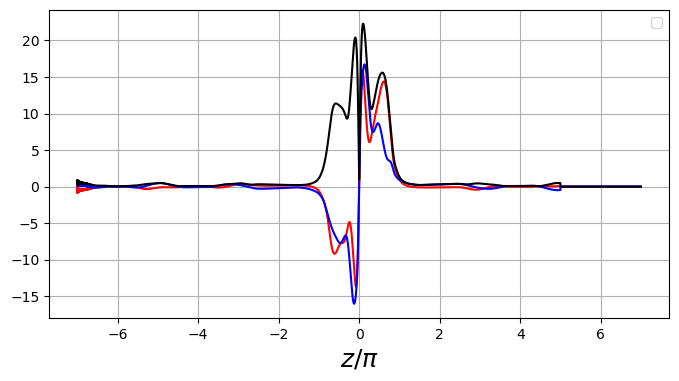

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.468336718497212 2.6771369421780276 2.8729887773697853 1.5629393213703278
0.040802651881517 0.07935163326010783 0.14814501298520025 1.5614861008503627


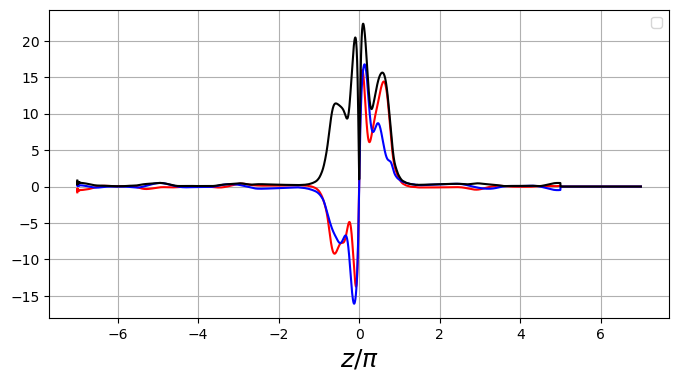

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.436916228903534 2.673202539182384 2.8689006635787355 1.5629413930468912
2.4595131220239344 2.6689323959091737 2.871132362375046 1.562942029610777
0.24185873106015057 0.4036939851234709 0.5899684938293797 1.5628616534929853


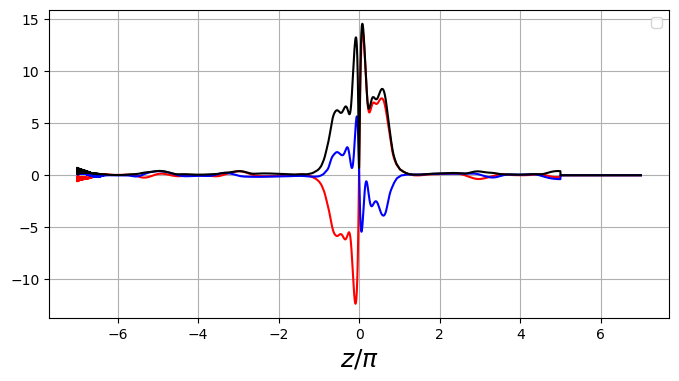

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.11178749013633409 0.20868553851286983 0.32670060868646095 1.562747491192869


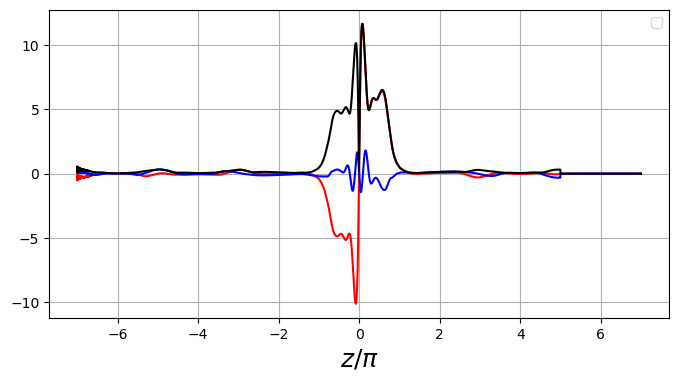

2.4673911455049504 2.6774841529582445 2.9028315923154278 1.5629423346070612
0.04268573501248894 0.08111878944385832 0.15319462170321463 1.561768940519452


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


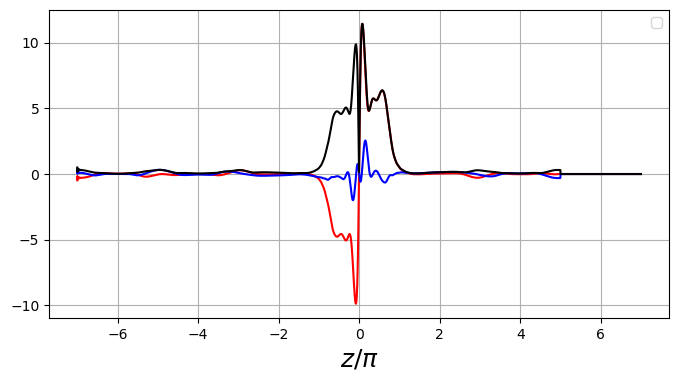

2.438785841219244 2.673509907486646 2.868586934801803 1.562941627493042
2.4331367515196707 2.671674590723006 2.8685844831455576 1.5629402917149438
0.2644994347959741 0.4024381092333029 0.562651296270316 1.5628548212357507


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


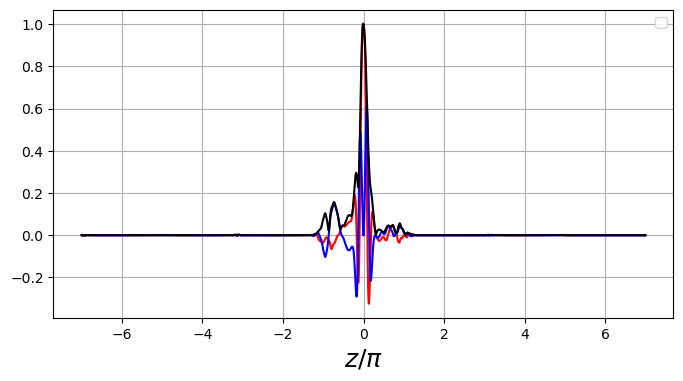

0.14945001605557062 0.23400540744311948 0.34035985274168346 1.5620038442782858


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


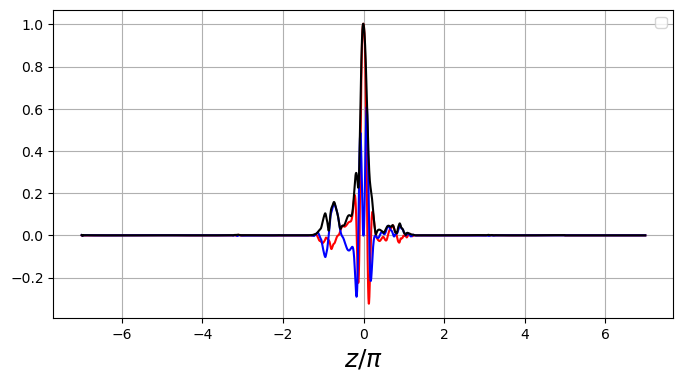

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4417000826941253 2.661968389547292 2.8563430692640157 1.562941893537301
0.09885121591958258 0.14888176006464302 0.22156793968260716 1.561221584761661


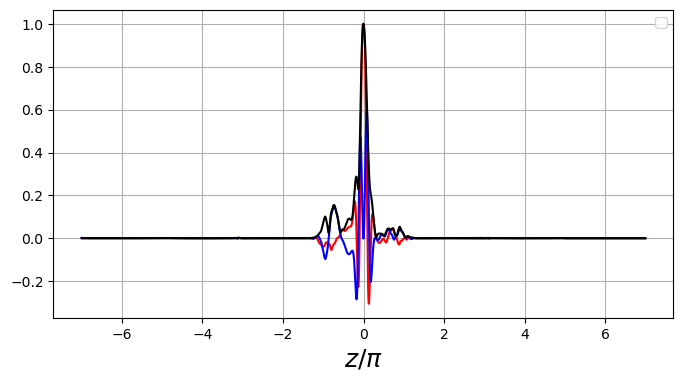

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.0938493281726394 2.3275603928917232 2.5431428137480903 1.5629375175596039
2.4259255245040348 2.651255496084537 2.8516262528771783 1.5629394661867688
2.4416442815373944 2.6811661017057977 2.87706875068444 1.5629413665270893
2.4410095143537305 2.68023797203902 2.876442088092016 1.5629422660831995
2.46308555526802 2.6812624871011645 2.8770686540792103 1.5629413140471797
2.441320653576738 2.6806380988880854 2.903817474526405 1.5629403326537883
0.256608772993887 0.4258267760097103 0.5979134419252783 1.5629157354936343


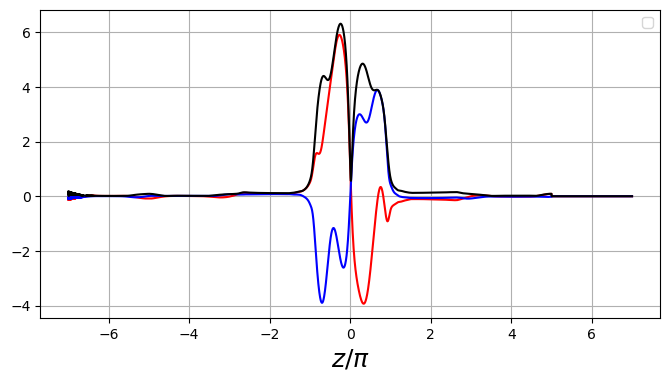

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.1394547581258618 0.2670919619332393 0.41657377517425737 1.562760269571263


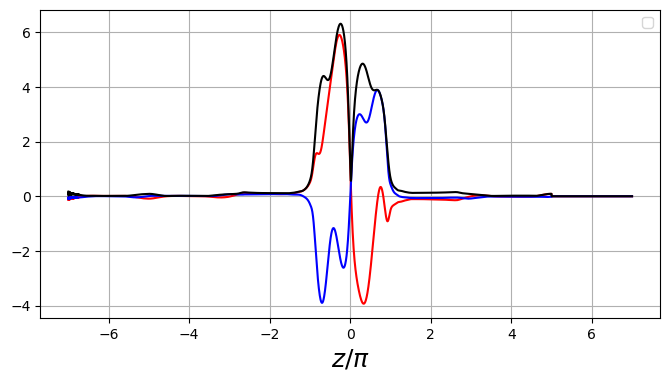

2.4384250213758785 2.673168365924545 2.8682890284295213 1.5629419243527551
0.037620174794470315 0.07032930024826604 0.13452798909104083 1.559994745592747


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


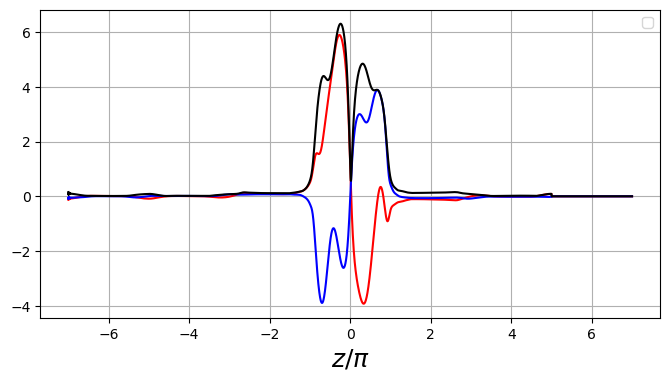

2.4464964476302202 2.674709278687941 2.872998521775515 1.562940349788486
2.465193942087048 2.673390656134132 2.870474122664836 1.5629385670125187
0.23932200633730352 0.4099194968344997 0.5897732259726849 1.5626564051948488


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


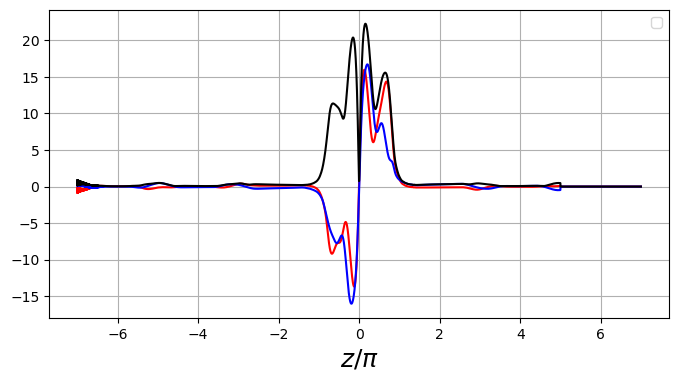

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.12748217111337998 0.2307551730537647 0.35367566794688937 1.5626086881159607


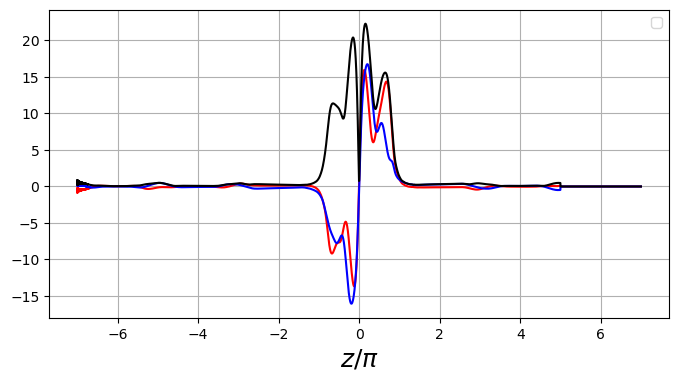

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4611942706710854 2.677001684853632 2.8742430020033582 1.5629422816664889
0.040684749241230174 0.07479443095146805 0.1396694372874545 1.557273533180382


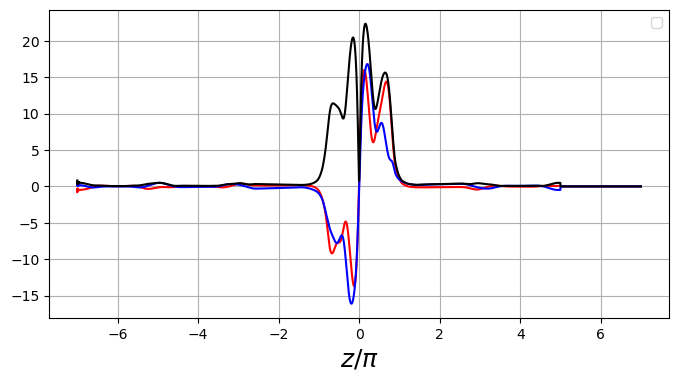

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.462684367808642 2.672482534913034 2.86764314331367 1.5629409112604637
2.4548135291734026 2.667499875798279 2.8687164623488077 1.5629351746092155
0.2544012995842529 0.4142472153166441 0.5846542166253372 1.5625747281479776


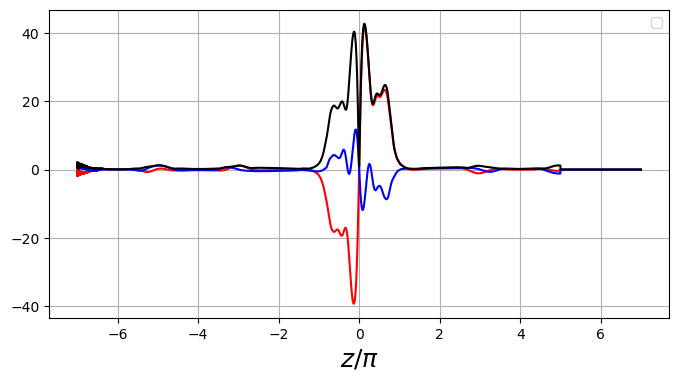

0.1234341015126818 0.21697743105684697 0.34080815826400557 1.5626557796948708


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


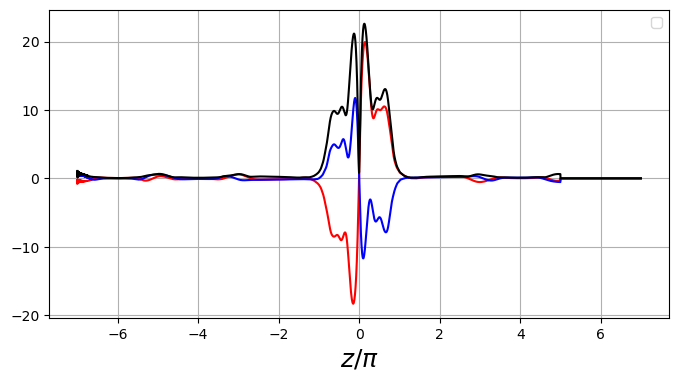

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.439752533135276 2.6774924283050696 2.9031687766369414 1.562942045570324
0.042595205095569445 0.07636764732664617 0.14375881719754685 1.5581701864004254


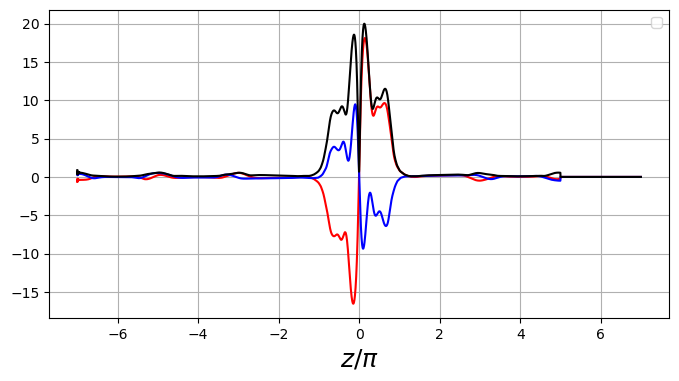

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.435973382623583 2.673500481604524 2.8723545712569356 1.5629361170950804
2.4633011291918563 2.671461142508295 2.8698457964527044 1.5629385620019876
0.2625630732736201 0.3928105065930919 0.5503624788987285 1.562548269429421


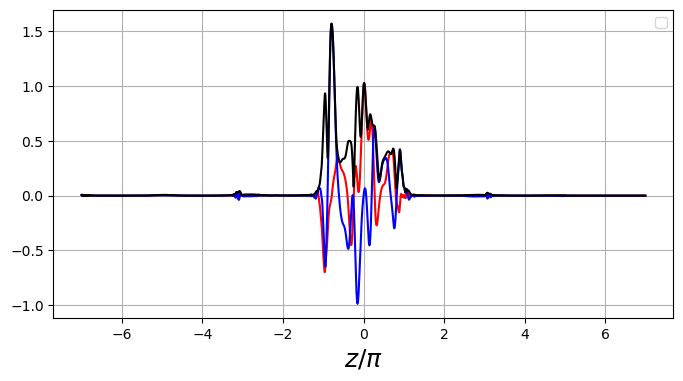

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.12335411418856344 0.19013989912643917 0.28039806980870907 1.562040644194981


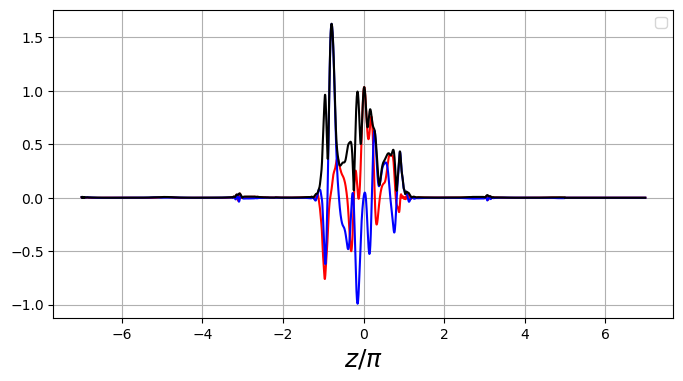

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.4570195849527274 2.6662883251055964 2.8626298990619437 1.5629395962306138
0.08528418188110033 0.12741213459295272 0.18372926187280178 1.5543137827950333


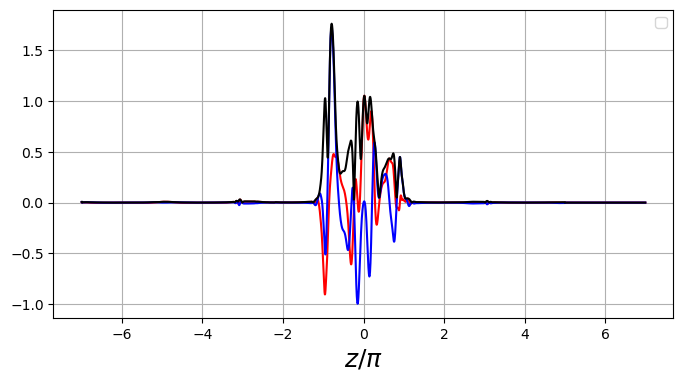

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.45038458106549 2.6644219507409126 2.860448362502929 1.5629406160780295
2.4652309381209716 2.680904253290635 2.8770701097302953 1.5629421048163592
2.4416454899223616 2.6799570999624356 2.87675601533956 1.562942140036509
2.441321549889729 2.6805689191392794 2.8764395858679723 1.5629409064758804
2.469282913240242 2.6767813836904 2.8972461890218453 1.5629416751796539
2.466141111116786 2.6764478760861166 2.895360986729549 1.5629415415725536
0.2610498242079376 0.42690738720124954 0.6100848820450914 1.5628904304395312


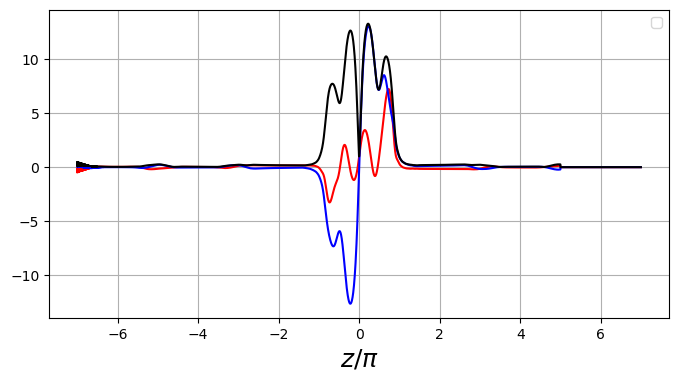

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.13443453911989808 0.24062719149170864 0.3682224696643685 1.5628270408260145


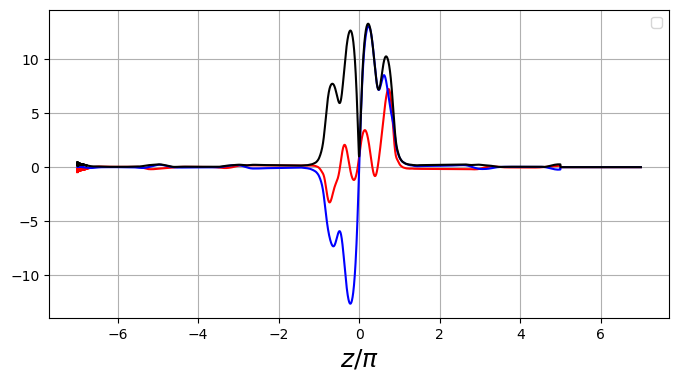

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.440063450479333 2.6789184601247586 2.875809543057344 1.5629399690529044
0.037202197073853915 0.06580265656519407 0.11820433325357109 1.5556287492533993


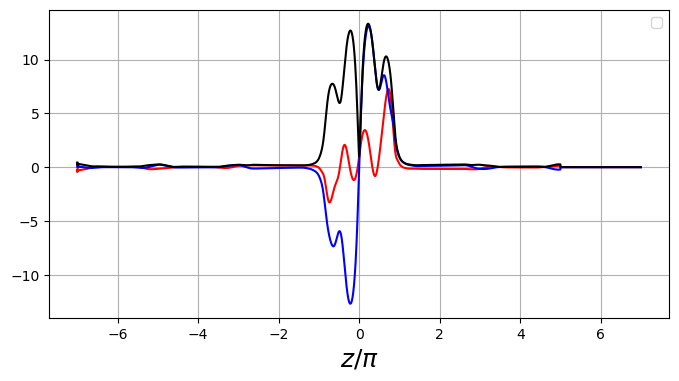

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.461733548650362 2.671578644497725 2.868907064186707 1.5629406012717733
2.451364707875682 2.6671302694765613 2.8623000087730075 1.5629395833218873
2.4623629091153347 2.673316333272426 2.867957947845277 1.562941263066081
2.4563776780144826 2.6711494765152928 2.861061572927366 1.5629409441381843
0.2519074638215163 0.4029198631205077 0.5579504895486197 1.5628865253462738


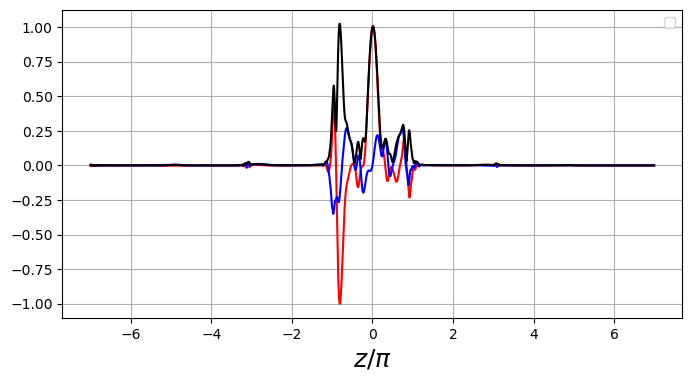

0.11726854665711389 0.18550018505181562 0.2652829479829356 1.5600267922164357


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


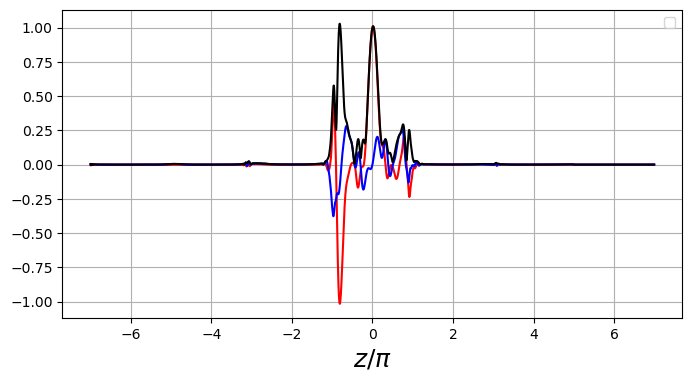

2.457666119917187 2.6669663756483843 2.8623343711079485 1.5629411922009462
0.0766039871296378 0.11188111501380155 0.16421194863998786 1.5619050654506068


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


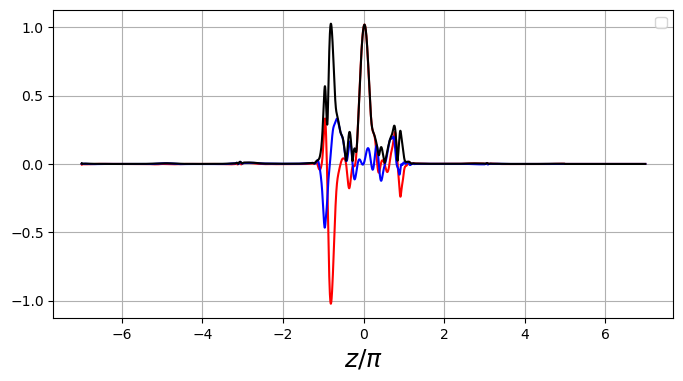

In [ ]:


for ind, row in analysis_sim_df.iterrows():

    field_name = 'phi'
    phi_array = row[field_name]
    zgrid = row['zgrid']

    if isinstance(phi_array, np.ndarray):
        
        ave_freq = row[f'{field_name}_angle_info']['ave_angle']
        lower_95_freq = row[f'{field_name}_angle_info']['lower_95_angle']
        upper_95_freq = row[f'{field_name}_angle_info']['upper_95_angle']
        max_freq = max(row[f'{field_name}_angle_info']['angles'])

        print(lower_95_freq, ave_freq, upper_95_freq, max_freq/2)

        if upper_95_freq < max_freq/2:
            plotting_function(phi_array, zgrid, field_name)